In [1]:
import pandas as pd
import re
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import spacy
import seaborn as sns
from torch.utils.data import WeightedRandomSampler
import numpy as np 



c:\Simoh\Github\BERT_Response_Validity_Checker\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# PRE

In [4]:
LANGUAGE = "en"

In [160]:
# --- 1. Charger et Préparer les Données ---

if LANGUAGE == "en":
    df = pd.read_csv('../../data/data_en_motsclé.csv')
    
elif LANGUAGE == "fr":
    df = pd.read_csv('../../data/data_vrsmall_fr.csv')

print("Aperçu initial des données:")
print(df.head())
print(f"\nDimensions du DataFrame: {df.shape}")
print(f"\nDistribution des labels:\n{df['label'].value_counts(normalize=True)}")

def clean_text(text):
    text = str(text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s\.\?,!àâéèêëîïôûùüçÀÂÉÈÊËÎÏÔÛÙÜÇ\']', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned_question'] = df['question'].apply(clean_text)
df['cleaned_answer'] = df['answer'].apply(clean_text)


print(df[['cleaned_question', 'cleaned_answer', 'label']].head())


Aperçu initial des données:
                                question  \
0  Do you have a color or style in mind?   
1                What's your usual size?   
2  Do you have a color or style in mind?   
3                Do you like this model?   
4  Do you have a color or style in mind?   

                                                   answer  label  
0            I’m looking for a blueprint for a birdhouse.      0  
1       I'm not sure, what size is the mannequin wearing?      1  
2               I saw a blue heron at the lake last week.      0  
3                   To be honest, I don't like the style.      1  
4  For the color, I'd prefer blue. The style is flexible.      1  

Dimensions du DataFrame: (501, 3)

Distribution des labels:
label
0    0.51497
1    0.48503
Name: proportion, dtype: float64
                        cleaned_question  \
0  do you have a color or style in mind?   
1                what's your usual size?   
2  do you have a color or style in mind?   
3  

In [182]:

# --- 2. Préparer les Données pour CamemBERT ---
#MODEL_NAME = "bert-base-uncased"

if LANGUAGE == "en":
    MODEL_NAME = "distilbert-base-uncased" # Or "roberta-base", "distilbert-base-uncased", etc.
elif LANGUAGE == "fr":
    MODEL_NAME = "camembert-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class QACoherenceDataset(Dataset):
    def __init__(self, questions, answers, labels, tokenizer, max_len):
        self.questions = questions
        self.answers = answers
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, item):
        question = str(self.questions[item])
        answer = str(self.answers[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            question,
            answer,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

X_questions_train, X_questions_test, \
X_answers_train, X_answers_test, \
y_train, y_test = train_test_split(
    df['cleaned_question'],
    df['cleaned_answer'],
    df['label'],
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

MAX_LEN = 90
train_dataset = QACoherenceDataset(
    questions=X_questions_train.values,
    answers=X_answers_train.values,
    labels=y_train.values, 
    tokenizer=tokenizer,
    max_len=MAX_LEN
)
test_dataset = QACoherenceDataset(
    questions=X_questions_test.values,
    answers=X_answers_test.values,
    labels=y_test.values, 
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

BATCH_SIZE = 16

if isinstance(y_train, pd.Series):
    y_train_numpy = y_train.values
else:
    y_train_numpy = y_train # Si c'est déjà un array numpy

class_counts = np.bincount(y_train_numpy)
print(f"Comptes des classes dans l'ensemble d'entraînement : {class_counts}")


class_weights_sample = 1. / class_counts
class_weights_sample = [1.0, 2]
print(f"Poids inverses des fréquences des classes : {class_weights_sample}")

sample_weights = np.array([class_weights_sample[label] for label in y_train_numpy])
sample_weights_tensor = torch.from_numpy(sample_weights).double()

sampler = WeightedRandomSampler(
    weights=sample_weights_tensor,
    num_samples=len(sample_weights_tensor),
    replacement=True
)


train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler
)


test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE
)




Comptes des classes dans l'ensemble d'entraînement : [206 194]
Poids inverses des fréquences des classes : [1.0, 2]


c:\Simoh\Github\BERT_Response_Validity_Checker\.venv\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [183]:

# --- 3. Définir le Modèle, l'Optimiseur, le Scheduler ---

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUtilisation du device: {device}")

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model = model.to(device)

LEARNING_RATE = 2e-5
ADAM_EPSILON = 1e-8
EPOCHS = 4

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=ADAM_EPSILON)
total_steps = len(train_loader) * EPOCHS
num_warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=total_steps
)



Utilisation du device: cpu


c:\Simoh\Github\BERT_Response_Validity_Checker\.venv\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [184]:
# --- 4. Fonctions d'Entraînement et d'Évaluation ---

def train_epoch_fn(model, data_loader, optimizer, scheduler, device, n_examples):
    model.train()
    total_loss = 0
    correct_predictions = 0
    for batch_idx, batch in enumerate(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
    return correct_predictions.double() / n_examples, total_loss / len(data_loader)

def eval_model_fn(model, data_loader, device, n_examples):
    model.eval()
    total_eval_loss = 0
    correct_predictions = 0
    all_true_labels = []
    all_pred_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            total_eval_loss += loss.item()
            all_true_labels.extend(labels.cpu().numpy())
            all_pred_labels.extend(preds.cpu().numpy())
    avg_loss = total_eval_loss / len(data_loader)
    accuracy = correct_predictions.double() / n_examples
    return accuracy, avg_loss, all_true_labels, all_pred_labels



In [ ]:

# --- 5. Boucle d'Entraînement ---

best_val_accuracy = 0
best_val_f1_minority = 0 
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_f1_minority': []}

for epoch in range(EPOCHS):
    print(f'--- Epoch {epoch + 1}/{EPOCHS} ---')
    train_acc, train_loss = train_epoch_fn(
        model, train_loader, optimizer, scheduler, device, len(train_dataset)
    )
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc.item())
    print(f'  Train loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}')

    val_acc, val_loss, val_true, val_pred = eval_model_fn(
        model, test_loader, device, len(test_dataset)
    )
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc.item())
    
    # Calculer le F1-score pour la classe minoritaire (label 1)
    val_f1_class1 = f1_score(val_true, val_pred, pos_label=1, zero_division=0)
    history['val_f1_minority'].append(val_f1_class1)

    print(f'  Val. loss: {val_loss:.4f} | Val. Accuracy: {val_acc:.4f} | Val. F1 (Classe 1): {val_f1_class1:.4f}')

    # Condition de sauvegarde basée sur le F1-score de la classe minoritaire
    if val_f1_class1 > best_val_f1_minority:
        best_val_f1_minority = val_f1_class1
        print(f"  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: {best_val_f1_minority:.4f}")




--- Epoch 1/4 ---
  Train loss: 0.6167 | Train Accuracy: 0.6550
  Val. loss: 0.7464 | Val. Acc: 0.4851 | Val. Recall (Cl. 1): 1.0000 | Val. F1 (Cl. 1): 0.6533
  >> Nouveau meilleur modèle sauvegardé ! Recall: 1.0000, F1: 0.6533
--- Epoch 2/4 ---
  Train loss: 0.4555 | Train Accuracy: 0.7400
  Val. loss: 0.4451 | Val. Acc: 0.7624 | Val. Recall (Cl. 1): 0.9796 | Val. F1 (Cl. 1): 0.8000
--- Epoch 3/4 ---
  Train loss: 0.2665 | Train Accuracy: 0.9200
  Val. loss: 0.3131 | Val. Acc: 0.8614 | Val. Recall (Cl. 1): 0.9796 | Val. F1 (Cl. 1): 0.8727
--- Epoch 4/4 ---
  Train loss: 0.1949 | Train Accuracy: 0.9550
  Val. loss: 0.2161 | Val. Acc: 0.9307 | Val. Recall (Cl. 1): 0.9388 | Val. F1 (Cl. 1): 0.9293


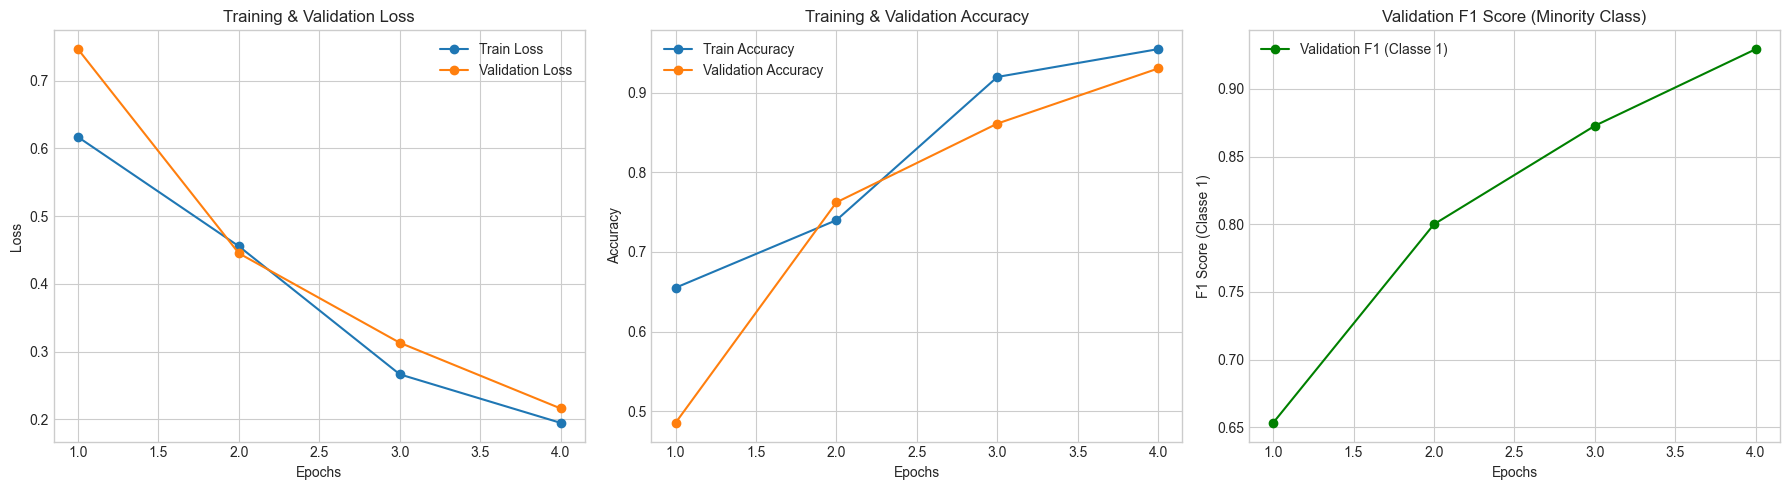

In [186]:
# --- 6. Visualisation des Courbes ---

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(18, 5))

# Plot 1: Loss (Training vs. Validation)
plt.subplot(1, 3, 1)
plt.plot(epochs_range, history['train_loss'], 'o-', label='Train Loss')
plt.plot(epochs_range, history['val_loss'], 'o-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy (Training vs. Validation)
plt.subplot(1, 3, 2)
plt.plot(epochs_range, history['train_acc'], 'o-', label='Train Accuracy')
plt.plot(epochs_range, history['val_acc'], 'o-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid(True)

# Plot 3: Validation F1-score (Minority Class)
plt.subplot(1, 3, 3)
plt.plot(epochs_range, history['val_f1_minority'], 'o-', label='Validation F1 (Classe 1)', color='green')
plt.xlabel('Epochs')
plt.ylabel('F1 Score (Classe 1)')
plt.title('Validation F1 Score (Minority Class)')
plt.legend()
plt.grid(True)

plt.tight_layout() # Ajuste automatiquement les subplots pour qu'ils ne se chevauchent pas
plt.show()


Évaluation finale du modèle sur l'ensemble de test...
Test Loss: 0.2161 | Test Accuracy: 0.9307
Métriques pour la Classe 1 (Cohérent):
  Precision: 0.9200
  Recall:    0.9388
  F1-score:  0.9293
Métriques pour la Classe 0 (Non Cohérent):
  Precision: 0.9412
  Recall:    0.9231
  F1-score:  0.9320


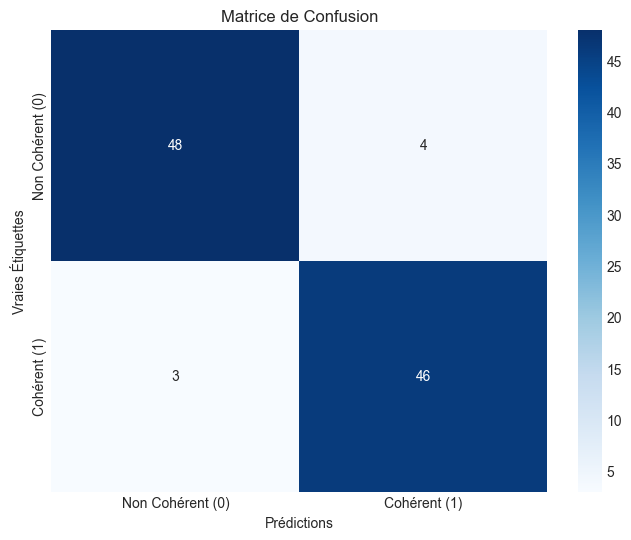

In [187]:

# --- 6. Évaluation Finale et Métriques détaillée ---

print("\nÉvaluation finale du modèle sur l'ensemble de test...")
final_test_acc, final_test_loss, true_labels, pred_labels = eval_model_fn(
    model, test_loader, device, len(test_dataset)
)
print(f'Test Loss: {final_test_loss:.4f} | Test Accuracy: {final_test_acc:.4f}')


# Spécifiez pos_label=1 pour être sûr que c'est pour la classe positive
precision_class1 = precision_score(true_labels, pred_labels, pos_label=1, zero_division=0)
recall_class1 = recall_score(true_labels, pred_labels, pos_label=1, zero_division=0)
f1_class1 = f1_score(true_labels, pred_labels, pos_label=1, zero_division=0)
print(f'Métriques pour la Classe 1 (Cohérent):')
print(f'  Precision: {precision_class1:.4f}')
print(f'  Recall:    {recall_class1:.4f}')
print(f'  F1-score:  {f1_class1:.4f}')

precision_class0 = precision_score(true_labels, pred_labels, pos_label=0, zero_division=0)
recall_class0 = recall_score(true_labels, pred_labels, pos_label=0, zero_division=0)
f1_class0 = f1_score(true_labels, pred_labels, pos_label=0, zero_division=0)
print(f'Métriques pour la Classe 0 (Non Cohérent):')
print(f'  Precision: {precision_class0:.4f}')
print(f'  Recall:    {recall_class0:.4f}')
print(f'  F1-score:  {f1_class0:.4f}')


cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Cohérent (0)', 'Cohérent (1)'], yticklabels=['Non Cohérent (0)', 'Cohérent (1)'])
plt.xlabel('Prédictions')
plt.ylabel('Vraies Étiquettes')
plt.title('Matrice de Confusion')
plt.show()



In [46]:
# Décoder les input_ids pour récupérer le texte
decoded_texts = [tokenizer.decode(item['input_ids'], skip_special_tokens=True) for item in test_dataset]

df_results = pd.DataFrame({
    'decoded_input': decoded_texts,
    'true_label': true_labels,
    'pred_label': pred_labels
})

# Afficher toutes les lignes (None signifie illimité)
pd.set_option('display.max_rows', None)

# Afficher toutes les colonnes si tu veux aussi
pd.set_option('display.max_columns', None)

# Afficher toute la largeur d’une colonne (pour éviter les "...")
pd.set_option('display.max_colwidth', None)

false_positives = df_results[(df_results['true_label'] == 0) & (df_results['pred_label'] == 1)]
false_negatives = df_results[(df_results['true_label'] == 1) & (df_results['pred_label'] == 0)]

print("==== FAUX POSITIFS ====") #Faux le model prédit Cohérent
print(false_positives[['decoded_input']])

print("\n==== FAUX NÉGATIFS ====")
print(false_negatives[['decoded_input']].head())


==== FAUX POSITIFS ====
Empty DataFrame
Columns: [decoded_input]
Index: []

==== FAUX NÉGATIFS ====
                                                  decoded_input
74              what's your usual size? my usual size is large.
95  what's your usual size? my size is typically an extralarge.


In [ ]:
# CELLULE POUR SAUVEGARDER LE MODÈLE ET LE TOKENIZER

# --- 7. Sauvegarder le modèle final entraîné ---
if LANGUAGE == "en":
    MODEL_SAVE_PATH = "en_save_model/distilbert_coherence_final_model.bin"
    TOKENIZER_SAVE_PATH = "en_save_model/distilbert_coherence_tokenizer/" # Un répertoire
    
elif LANGUAGE == "fr":
    MODEL_SAVE_PATH = "fr_save_model/camembert_coherence_final_model.bin"
    TOKENIZER_SAVE_PATH = "fr_save_model/camembert_coherence_tokenizer/" # Un répertoire

# S'assurer que le modèle est sur CPU avant de sauvegarder pour une meilleure portabilité
# (Surtout si vous comptez le charger sur une machine sans GPU)
model.to('cpu')
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Modèle final (state_dict) sauvegardé sous: {MODEL_SAVE_PATH}")

# Remettre le modèle sur son device original si besoin de continuer à l'utiliser dans cette session
model.to(device)

# Sauvegarder le tokenizer (contient vocabulaire, configuration, etc.)
tokenizer.save_pretrained(TOKENIZER_SAVE_PATH)
print(f"Tokenizer sauvegardé sous: {TOKENIZER_SAVE_PATH}")

print("\nSauvegarde terminée.")

Modèle final (state_dict) sauvegardé sous: en_save_model/bert_coherence_final_model.bin
Tokenizer sauvegardé sous: en_save_model/bert_coherence_tokenizer/

Sauvegarde terminée.


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import re

if LANGUAGE == "en":
    MODEL_NAME_FOR_TEST = "distilbert-base-uncased" # Or "roberta-base", "distilbert-base-uncased", etc."bert-base-uncased"
    MODEL_SAVE_PATH_FOR_LOAD = "en_save_model/distilbert_coherence_final_model.bin"
    TOKENIZER_SAVE_PATH_FOR_LOAD = "en_save_model/distilbert_coherence_tokenizer/"

elif LANGUAGE == "fr":
    MODEL_NAME_FOR_TEST = "camembert-base"
    MODEL_SAVE_PATH_FOR_LOAD = "fr_save_model/camembert_coherence_final_model.bin"
    TOKENIZER_SAVE_PATH_FOR_LOAD = "fr_save_model/camenbert_coherence_tokenizer/"

MAX_LEN_FOR_TEST = 90
DEVICE_FOR_TEST = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def clean_text_for_prediction(text):
    text = str(text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s\.\?,!àâéèêëîïôûùüçÀÂÉÈÊËÎÏÔÛÙÜÇ\']', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text


model_to_test = None
tokenizer_to_test = None
device_to_test = None
max_len_to_test = None
clean_text_func_to_use = None


tokenizer_to_test = AutoTokenizer.from_pretrained(TOKENIZER_SAVE_PATH_FOR_LOAD)


model_to_test = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME_FOR_TEST, num_labels=2)

# Charger les poids sauvegardés
model_to_test.load_state_dict(torch.load(MODEL_SAVE_PATH_FOR_LOAD, map_location=DEVICE_FOR_TEST))
model_to_test.to(DEVICE_FOR_TEST)
model_to_test.eval() 

max_len_to_test = MAX_LEN_FOR_TEST 
clean_text_func_to_use = clean_text_for_prediction
device_to_test = DEVICE_FOR_TEST 

print("Modèle et tokenizer chargés depuis le disque et prêts pour l'inférence.")


c:\Simoh\Github\BERT_Response_Validity_Checker\.venv\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modèle et tokenizer chargés depuis le disque et prêts pour l'inférence.


In [49]:
# --- Fonction de prédiction (utilise les variables _to_test) ---
def predict_coherence(question, answer, model, tokenizer, device, max_len, clean_fn):

    cleaned_question = clean_fn(question)
    cleaned_answer = clean_fn(answer)

    encoding = tokenizer.encode_plus(
        cleaned_question,
        cleaned_answer,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
        prediction_idx = torch.argmax(probs, dim=1).cpu().item()
        probability_score = probs[0][prediction_idx].cpu().item()

    return prediction_idx, probability_score

In [50]:

# --- Exemples de test ---
if LANGUAGE == "en":
    
    test_samples = [
    {
        "question": "Hello, what can I do for you today?",
        "answer": "i'm looking a bird and apple."
    },  # Coherent
    {
        "question": "Hello, what can I do for you today?",
        "answer": "I’m looking at the way the light reflects off that security tag."
    },  # Incoherent
    {
        "question": "What is your usual size?",
        "answer": "size"
    },  # Coherent
    {
        "question": "What is your usual size?",
        "answer": "The size of my disappointment is immeasurable."
    },  # Incoherent
    {
        "question": "Do you have a color or style in mind?",
        "answer": "I'm looking for something in a dark color, maybe black or navy blue."
    },  # Coherent
    {
        "question": "Do you have a color or style in mind?",
        "answer": "My favorite power ranger was the blue one."
    },  # Incoherent
    {
        "question": "Do you like this model?",
        "answer": "Yes, I like the fabric and the cut."
    },  # Coherent
    {
        "question": "Do you like this model?",
        "answer": "It feels like a Tuesday, doesn't it?"
    },  # Incoherent
    {
        "question": "Would you like to try something else or go to checkout?",
        "answer": "I'm ready to go to checkout, thank you."
    },  # Coherent
    {
        "question": "Would you like to try something else or go to checkout?",
        "answer": "I need to checkout the emergency exit map first."
    },  # Incoherent
]

elif LANGUAGE == "fr":
    
    test_samples = [
        {
            "question": "Bonjour, que puis-je faire pour vous aujourd'hui ?",
            "answer": "je vroudrais des chaussures."
        }, # Cohérent
        {
            "question": "Bonjour, que puis-je faire pour vous aujourd'hui ?",
            "answer": "je voudrais une pomme."
        }, # Incohérent
        {
            "question": "Quelle est votre taille habituelle ?",
            "answer": "surement 7XL."
        }, # Cohérent
        {
            "question": "Quelle est votre taille habituelle ?",
            "answer": "un panier de basket fait 3m05"
        }, # Incohérent
        {
            "question": "Avez-vous une couleur ou un style en tête ?",
            "answer": "je veux du noir et un style pour les meeting."
        }, # Cohérent
        {
            "question": "Avez-vous une couleur ou un style en tête ?",
            "answer": "le vert est la couleur du kiwi"
        }, # Incohérent
        {
            "question": "Ce modèle vous plaît-il ?",
            "answer": "un peu trop grand mais sinon c'est ce que je voulais."
        }, # Cohérent
        {
            "question": "Ce modèle vous plaît-il ?",
            "answer": "ouais mais je préfère mon poulet"
        }, # Incohérent
        {
            "question": "Souhaitez-vous essayer autre chose ou passer en caisse ?",
            "answer": "je vais changer cette article et je paye"
        }, # Cohérent
        {
            "question": "Souhaitez-vous essayer autre chose ou passer en caisse ?",
            "answer": "je veux payer avec ma pomme"
        },# Incohérent
    ]


In [51]:


for i, sample in enumerate(test_samples):
    q = sample["question"]
    a = sample["answer"]

    print(f"\nExemple {i+1}:")
    print(f"  Question: \"{q}\"")
    print(f"  Réponse:  \"{a}\"")

    pred_label, pred_prob = predict_coherence(q, a,
                                                model_to_test,
                                                tokenizer_to_test,
                                                device_to_test,
                                                max_len_to_test,
                                                clean_text_func_to_use)


    coherence_status = "Cohérent" if pred_label == 1 else "Non Cohérent"
    print(f"  Prédiction: {coherence_status} (Label: {pred_label}, Confiance: {pred_prob:.4f})")



Exemple 1:
  Question: "Hello, what can I do for you today?"
  Réponse:  "i'm looking a bird and apple."
  Prédiction: Cohérent (Label: 1, Confiance: 0.6557)

Exemple 2:
  Question: "Hello, what can I do for you today?"
  Réponse:  "I’m looking at the way the light reflects off that security tag."
  Prédiction: Non Cohérent (Label: 0, Confiance: 0.9699)

Exemple 3:
  Question: "What is your usual size?"
  Réponse:  "size"
  Prédiction: Non Cohérent (Label: 0, Confiance: 0.9461)

Exemple 4:
  Question: "What is your usual size?"
  Réponse:  "The size of my disappointment is immeasurable."
  Prédiction: Non Cohérent (Label: 0, Confiance: 0.9632)

Exemple 5:
  Question: "Do you have a color or style in mind?"
  Réponse:  "I'm looking for something in a dark color, maybe black or navy blue."
  Prédiction: Cohérent (Label: 1, Confiance: 0.9666)

Exemple 6:
  Question: "Do you have a color or style in mind?"
  Réponse:  "My favorite power ranger was the blue one."
  Prédiction: Non Cohérent

# Hyperpram

In [128]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

lam=np.linspace(1.0, 5.0, 10)

results = {
    'lam': [],
    'precision_0': [], 'recall_0': [], 'f1_0': [],
    'precision_1': [], 'recall_1': [], 'f1_1': [],
    'accuracy': []
}
for i in range(len(lam)):
    class_weights_sample = [1.0, lam[i]]
    print(f"Poids inverses des fréquences des classes : {class_weights_sample}")

    sample_weights = np.array([class_weights_sample[label] for label in y_train_numpy])
    sample_weights_tensor = torch.from_numpy(sample_weights).double()

    sampler = WeightedRandomSampler(
        weights=sample_weights_tensor,
        num_samples=len(sample_weights_tensor),
        replacement=True
    )


    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        sampler=sampler
    )


    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE
    )
    
    
    # --- 3. Définir le Modèle, l'Optimiseur, le Scheduler ---

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
    model = model.to(device)

    LEARNING_RATE = 2e-5
    ADAM_EPSILON = 1e-8
    EPOCHS = 10

    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=ADAM_EPSILON)
    total_steps = len(train_loader) * EPOCHS
    num_warmup_steps = int(0.1 * total_steps)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=total_steps
    )

    # --- 5. Boucle d'Entraînement ---

    best_val_accuracy = 0
    best_val_f1_minority = 0 
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_f1_minority': []}

    for epoch in range(EPOCHS):
        print(f'--- Epoch {epoch + 1}/{EPOCHS} ---')
        train_acc, train_loss = train_epoch_fn(
            model, train_loader, optimizer, scheduler, device, len(train_dataset)
        )
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc.item())
        print(f'  Train loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}')

        val_acc, val_loss, val_true, val_pred = eval_model_fn(
            model, test_loader, device, len(test_dataset)
        )
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc.item())
        
        # Calculer le F1-score pour la classe minoritaire (label 1)
        val_f1_class1 = f1_score(val_true, val_pred, pos_label=1, zero_division=0)
        history['val_f1_minority'].append(val_f1_class1)

        print(f'  Val. loss: {val_loss:.4f} | Val. Accuracy: {val_acc:.4f} | Val. F1 (Classe 1): {val_f1_class1:.4f}')

        # Condition de sauvegarde basée sur le F1-score de la classe minoritaire
        if val_f1_class1 > best_val_f1_minority:
            best_val_f1_minority = val_f1_class1
            print(f"  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: {best_val_f1_minority:.4f}")

    final_test_acc, final_test_loss, true_labels, pred_labels = eval_model_fn(
        model, test_loader, device, len(test_dataset)
    )
      
    results['lam'].append(lam[i])
    results['accuracy'].append(final_test_acc)
    
    
    results['precision_1'].append(precision_score(true_labels, pred_labels, pos_label=1, zero_division=0))
    results['recall_1'].append(recall_score(true_labels, pred_labels, pos_label=1, zero_division=0))
    results['f1_1'].append(f1_score(true_labels, pred_labels, pos_label=1, zero_division=0))
    
    
    results['precision_0'].append(precision_score(true_labels, pred_labels, pos_label=0, zero_division=0))
    results['recall_0'].append(recall_score(true_labels, pred_labels, pos_label=0, zero_division=0))
    results['f1_0'].append(f1_score(true_labels, pred_labels, pos_label=0, zero_division=0))

results_df = pd.DataFrame(results)
print("\n--- Tableau récapitulatif des résultats ---")
print(results_df)


Poids inverses des fréquences des classes : [1.0, np.float64(1.0)]


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Epoch 1/10 ---
  Train loss: 0.6807 | Train Accuracy: 0.6175
  Val. loss: 0.6382 | Val. Accuracy: 0.8317 | Val. F1 (Classe 1): 0.8350
  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: 0.8350
--- Epoch 2/10 ---
  Train loss: 0.4702 | Train Accuracy: 0.8700
  Val. loss: 0.2684 | Val. Accuracy: 0.9406 | Val. F1 (Classe 1): 0.9362
  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: 0.9362
--- Epoch 3/10 ---
  Train loss: 0.1855 | Train Accuracy: 0.9450
  Val. loss: 0.1258 | Val. Accuracy: 0.9604 | Val. F1 (Classe 1): 0.9592
  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: 0.9592
--- Epoch 4/10 ---
  Train loss: 0.0701 | Train Accuracy: 0.9875
  Val. loss: 0.0940 | Val. Accuracy: 0.9604 | Val. F1 (Classe 1): 0.9608
  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: 0.9608
--- Epoch 5/10 ---
  Train loss: 0.0469 | Train Accuracy: 0.9900
  Val. loss: 0.0756 | Val. Accuracy: 0.9703 | Val. F1 (Classe 1): 0.9691
  Nouveau meilleur modèle 

c:\Simoh\Github\BERT_Response_Validity_Checker\.venv\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Epoch 1/10 ---
  Train loss: 0.7000 | Train Accuracy: 0.5000
  Val. loss: 0.6832 | Val. Accuracy: 0.4851 | Val. F1 (Classe 1): 0.6533
  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: 0.6533
--- Epoch 2/10 ---
  Train loss: 0.5599 | Train Accuracy: 0.7150
  Val. loss: 0.3815 | Val. Accuracy: 0.8317 | Val. F1 (Classe 1): 0.8496
  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: 0.8496
--- Epoch 3/10 ---
  Train loss: 0.2452 | Train Accuracy: 0.9325
  Val. loss: 0.1274 | Val. Accuracy: 0.9604 | Val. F1 (Classe 1): 0.9583
  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: 0.9583
--- Epoch 4/10 ---
  Train loss: 0.0703 | Train Accuracy: 0.9850
  Val. loss: 0.0604 | Val. Accuracy: 0.9802 | Val. F1 (Classe 1): 0.9796
  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: 0.9796
--- Epoch 5/10 ---
  Train loss: 0.0246 | Train Accuracy: 0.9950
  Val. loss: 0.1025 | Val. Accuracy: 0.9604 | Val. F1 (Classe 1): 0.9608
--- Epoch 6/10 ---
  Train

c:\Simoh\Github\BERT_Response_Validity_Checker\.venv\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Epoch 1/10 ---
  Train loss: 0.6630 | Train Accuracy: 0.6150
  Val. loss: 0.6815 | Val. Accuracy: 0.5842 | Val. F1 (Classe 1): 0.7000
  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: 0.7000
--- Epoch 2/10 ---
  Train loss: 0.4783 | Train Accuracy: 0.7725
  Val. loss: 0.3426 | Val. Accuracy: 0.8812 | Val. F1 (Classe 1): 0.8889
  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: 0.8889
--- Epoch 3/10 ---
  Train loss: 0.1697 | Train Accuracy: 0.9675
  Val. loss: 0.1593 | Val. Accuracy: 0.9406 | Val. F1 (Classe 1): 0.9362
  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: 0.9362
--- Epoch 4/10 ---
  Train loss: 0.1127 | Train Accuracy: 0.9650
  Val. loss: 0.3178 | Val. Accuracy: 0.9208 | Val. F1 (Classe 1): 0.9130
--- Epoch 5/10 ---
  Train loss: 0.0586 | Train Accuracy: 0.9825
  Val. loss: 0.1735 | Val. Accuracy: 0.9604 | Val. F1 (Classe 1): 0.9574
  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: 0.9574
--- Epoch 6/10 ---
  Train

c:\Simoh\Github\BERT_Response_Validity_Checker\.venv\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Epoch 1/10 ---
  Train loss: 0.6565 | Train Accuracy: 0.5925
  Val. loss: 0.8053 | Val. Accuracy: 0.4851 | Val. F1 (Classe 1): 0.6533
  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: 0.6533
--- Epoch 2/10 ---
  Train loss: 0.4765 | Train Accuracy: 0.7250
  Val. loss: 0.4370 | Val. Accuracy: 0.7426 | Val. F1 (Classe 1): 0.7903
  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: 0.7903
--- Epoch 3/10 ---
  Train loss: 0.2356 | Train Accuracy: 0.9150
  Val. loss: 0.1893 | Val. Accuracy: 0.9604 | Val. F1 (Classe 1): 0.9608
  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: 0.9608
--- Epoch 4/10 ---
  Train loss: 0.0952 | Train Accuracy: 0.9800
  Val. loss: 0.1344 | Val. Accuracy: 0.9703 | Val. F1 (Classe 1): 0.9684
  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: 0.9684
--- Epoch 5/10 ---
  Train loss: 0.0581 | Train Accuracy: 0.9825
  Val. loss: 0.0784 | Val. Accuracy: 0.9802 | Val. F1 (Classe 1): 0.9796
  Nouveau meilleur modèle 

c:\Simoh\Github\BERT_Response_Validity_Checker\.venv\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Epoch 1/10 ---
  Train loss: 0.6625 | Train Accuracy: 0.5450
  Val. loss: 0.8512 | Val. Accuracy: 0.4851 | Val. F1 (Classe 1): 0.6533
  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: 0.6533
--- Epoch 2/10 ---
  Train loss: 0.4498 | Train Accuracy: 0.7725
  Val. loss: 0.5257 | Val. Accuracy: 0.6238 | Val. F1 (Classe 1): 0.7206
  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: 0.7206
--- Epoch 3/10 ---
  Train loss: 0.2894 | Train Accuracy: 0.8600
  Val. loss: 0.3410 | Val. Accuracy: 0.9109 | Val. F1 (Classe 1): 0.9159
  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: 0.9159
--- Epoch 4/10 ---
  Train loss: 0.1537 | Train Accuracy: 0.9600
  Val. loss: 0.2285 | Val. Accuracy: 0.9109 | Val. F1 (Classe 1): 0.9143
--- Epoch 5/10 ---
  Train loss: 0.1222 | Train Accuracy: 0.9675
  Val. loss: 0.1959 | Val. Accuracy: 0.9109 | Val. F1 (Classe 1): 0.9126
--- Epoch 6/10 ---
  Train loss: 0.0333 | Train Accuracy: 0.9925
  Val. loss: 0.1696 | Val. Accur

c:\Simoh\Github\BERT_Response_Validity_Checker\.venv\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Epoch 1/10 ---
  Train loss: 0.6258 | Train Accuracy: 0.7050
  Val. loss: 0.8179 | Val. Accuracy: 0.4851 | Val. F1 (Classe 1): 0.6533
  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: 0.6533
--- Epoch 2/10 ---
  Train loss: 0.4114 | Train Accuracy: 0.7725
  Val. loss: 0.4572 | Val. Accuracy: 0.6733 | Val. F1 (Classe 1): 0.7442
  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: 0.7442
--- Epoch 3/10 ---
  Train loss: 0.2267 | Train Accuracy: 0.9125
  Val. loss: 0.2411 | Val. Accuracy: 0.9208 | Val. F1 (Classe 1): 0.9184
  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: 0.9184
--- Epoch 4/10 ---
  Train loss: 0.1181 | Train Accuracy: 0.9575
  Val. loss: 0.3267 | Val. Accuracy: 0.8614 | Val. F1 (Classe 1): 0.8333
--- Epoch 5/10 ---
  Train loss: 0.0797 | Train Accuracy: 0.9750
  Val. loss: 0.1273 | Val. Accuracy: 0.9505 | Val. F1 (Classe 1): 0.9474
  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: 0.9474
--- Epoch 6/10 ---
  Train

c:\Simoh\Github\BERT_Response_Validity_Checker\.venv\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Epoch 1/10 ---
  Train loss: 0.5794 | Train Accuracy: 0.7850
  Val. loss: 0.9753 | Val. Accuracy: 0.4851 | Val. F1 (Classe 1): 0.6533
  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: 0.6533
--- Epoch 2/10 ---
  Train loss: 0.4563 | Train Accuracy: 0.7875
  Val. loss: 0.6408 | Val. Accuracy: 0.6238 | Val. F1 (Classe 1): 0.7206
  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: 0.7206
--- Epoch 3/10 ---
  Train loss: 0.2937 | Train Accuracy: 0.8525
  Val. loss: 0.3048 | Val. Accuracy: 0.9010 | Val. F1 (Classe 1): 0.9057
  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: 0.9057
--- Epoch 4/10 ---
  Train loss: 0.1515 | Train Accuracy: 0.9500
  Val. loss: 0.1749 | Val. Accuracy: 0.9505 | Val. F1 (Classe 1): 0.9485
  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: 0.9485
--- Epoch 5/10 ---
  Train loss: 0.0736 | Train Accuracy: 0.9850
  Val. loss: 0.1665 | Val. Accuracy: 0.9406 | Val. F1 (Classe 1): 0.9388
--- Epoch 6/10 ---
  Train

c:\Simoh\Github\BERT_Response_Validity_Checker\.venv\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Epoch 1/10 ---
  Train loss: 0.6278 | Train Accuracy: 0.5725
  Val. loss: 1.1216 | Val. Accuracy: 0.4851 | Val. F1 (Classe 1): 0.6533
  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: 0.6533
--- Epoch 2/10 ---
  Train loss: 0.4054 | Train Accuracy: 0.8250
  Val. loss: 0.6759 | Val. Accuracy: 0.6238 | Val. F1 (Classe 1): 0.7206
  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: 0.7206
--- Epoch 3/10 ---
  Train loss: 0.2425 | Train Accuracy: 0.9075
  Val. loss: 0.3940 | Val. Accuracy: 0.8614 | Val. F1 (Classe 1): 0.8750
  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: 0.8750
--- Epoch 4/10 ---
  Train loss: 0.1652 | Train Accuracy: 0.9525
  Val. loss: 0.1755 | Val. Accuracy: 0.9406 | Val. F1 (Classe 1): 0.9388
  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: 0.9388
--- Epoch 5/10 ---
  Train loss: 0.0777 | Train Accuracy: 0.9825
  Val. loss: 0.1423 | Val. Accuracy: 0.9406 | Val. F1 (Classe 1): 0.9362
--- Epoch 6/10 ---
  Train

c:\Simoh\Github\BERT_Response_Validity_Checker\.venv\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Epoch 1/10 ---
  Train loss: 0.5768 | Train Accuracy: 0.7975
  Val. loss: 0.9992 | Val. Accuracy: 0.4851 | Val. F1 (Classe 1): 0.6533
  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: 0.6533
--- Epoch 2/10 ---
  Train loss: 0.3522 | Train Accuracy: 0.8425
  Val. loss: 0.7479 | Val. Accuracy: 0.6238 | Val. F1 (Classe 1): 0.7206
  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: 0.7206
--- Epoch 3/10 ---
  Train loss: 0.2500 | Train Accuracy: 0.8975
  Val. loss: 0.2651 | Val. Accuracy: 0.9010 | Val. F1 (Classe 1): 0.9057
  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: 0.9057
--- Epoch 4/10 ---
  Train loss: 0.0665 | Train Accuracy: 0.9950
  Val. loss: 0.1433 | Val. Accuracy: 0.9406 | Val. F1 (Classe 1): 0.9400
  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: 0.9400
--- Epoch 5/10 ---
  Train loss: 0.0614 | Train Accuracy: 0.9775
  Val. loss: 0.1264 | Val. Accuracy: 0.9505 | Val. F1 (Classe 1): 0.9474
  Nouveau meilleur modèle 

c:\Simoh\Github\BERT_Response_Validity_Checker\.venv\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Epoch 1/10 ---
  Train loss: 0.6015 | Train Accuracy: 0.6850
  Val. loss: 0.9977 | Val. Accuracy: 0.4851 | Val. F1 (Classe 1): 0.6533
  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: 0.6533
--- Epoch 2/10 ---
  Train loss: 0.3822 | Train Accuracy: 0.8350
  Val. loss: 0.7708 | Val. Accuracy: 0.6238 | Val. F1 (Classe 1): 0.7206
  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: 0.7206
--- Epoch 3/10 ---
  Train loss: 0.2207 | Train Accuracy: 0.9000
  Val. loss: 0.3225 | Val. Accuracy: 0.8812 | Val. F1 (Classe 1): 0.8889
  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: 0.8889
--- Epoch 4/10 ---
  Train loss: 0.1156 | Train Accuracy: 0.9675
  Val. loss: 0.1568 | Val. Accuracy: 0.9505 | Val. F1 (Classe 1): 0.9462
  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: 0.9462
--- Epoch 5/10 ---
  Train loss: 0.0604 | Train Accuracy: 0.9850
  Val. loss: 0.1451 | Val. Accuracy: 0.9505 | Val. F1 (Classe 1): 0.9462
--- Epoch 6/10 ---
  Train

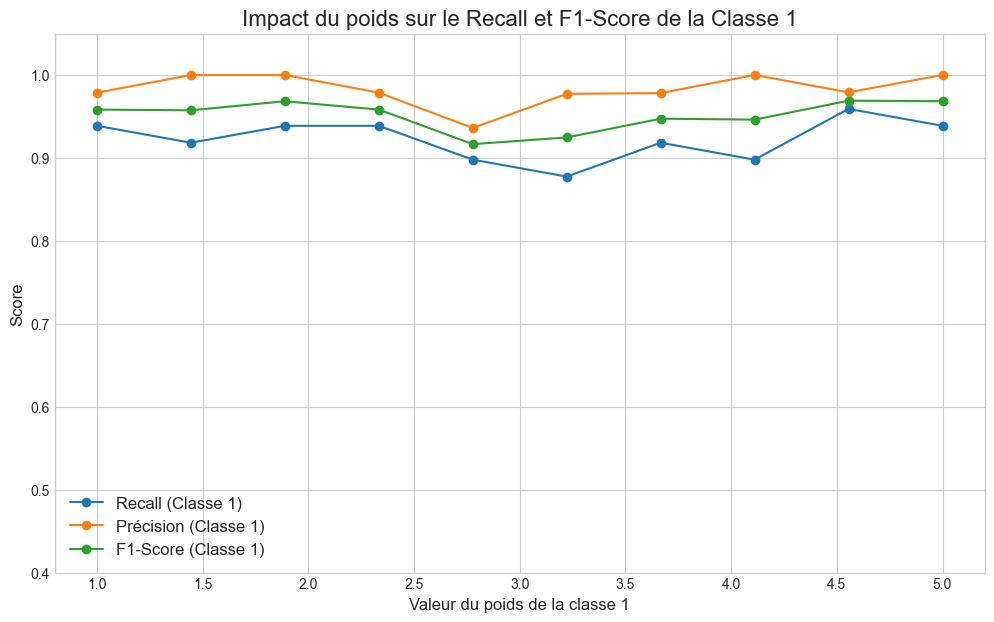

In [129]:

plt.figure(figsize=(12, 7))


plt.plot(results_df['lam'], results_df['recall_1'],'o-',  label='Recall (Classe 1)')

plt.plot(results_df['lam'], results_df['precision_1'], 'o-', label='Précision (Classe 1)')

plt.plot(results_df['lam'], results_df['f1_1'],'o-', label='F1-Score (Classe 1)')




plt.title('Impact du poids sur le Recall et F1-Score de la Classe 1', fontsize=16)
plt.xlabel('Valeur du poids de la classe 1', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.legend(fontsize=12)
plt.ylim(0.4, 1.05) 
plt.show()

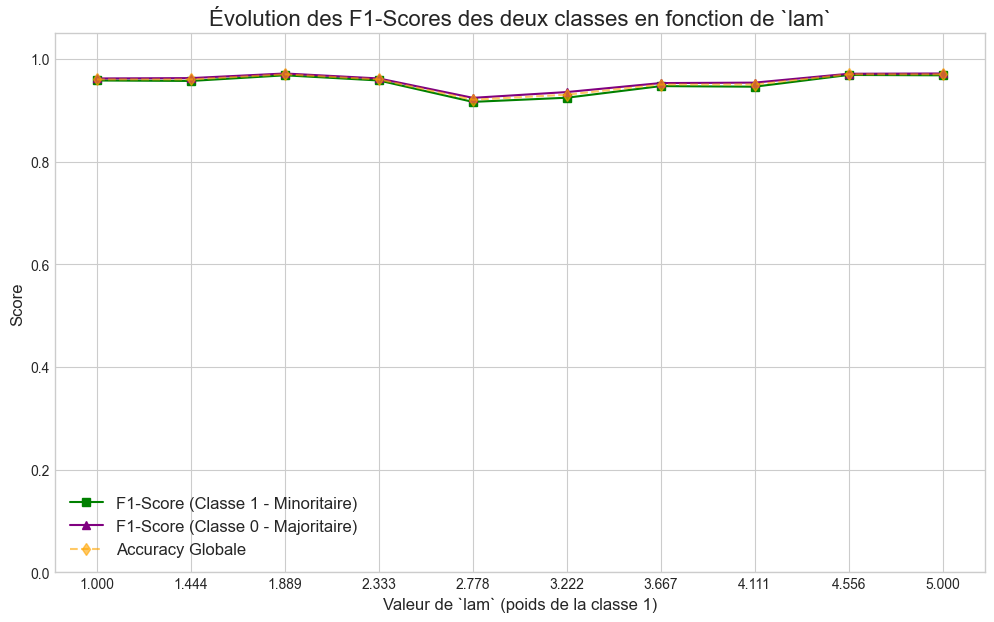

In [130]:
plt.figure(figsize=(12, 7))

# F1-score pour chaque classe
plt.plot(results_df['lam'], results_df['f1_1'], 's-', label='F1-Score (Classe 1 - Minoritaire)', color='green')
plt.plot(results_df['lam'], results_df['f1_0'], '^-', label='F1-Score (Classe 0 - Majoritaire)', color='purple')

# Vous pouvez aussi ajouter l'accuracy générale
plt.plot(results_df['lam'], results_df['accuracy'], 'd--', label='Accuracy Globale', color='orange', alpha=0.6)

plt.title("Évolution des F1-Scores des deux classes en fonction de `lam`", fontsize=16)
plt.xlabel('Valeur de `lam` (poids de la classe 1)', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(results_df['lam'])
plt.legend(fontsize=12)
plt.ylim(0, 1.05)
plt.show()

# Test

In [42]:
LANGUAGE = "en"

In [43]:
# --- 1. Charger et Préparer les Données ---

if LANGUAGE == "en":
    df = pd.read_csv('../../data/data_en_motsclé.csv')
    
elif LANGUAGE == "fr":
    df = pd.read_csv('../../data/data_vrsmall_fr.csv')

print("Aperçu initial des données:")
print(df.head())
print(f"\nDimensions du DataFrame: {df.shape}")
print(f"\nDistribution des labels:\n{df['label'].value_counts(normalize=True)}")

def clean_text(text):
    text = str(text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s\.\?,!àâéèêëîïôûùüçÀÂÉÈÊËÎÏÔÛÙÜÇ\']', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned_question'] = df['question'].apply(clean_text)
df['cleaned_answer'] = df['answer'].apply(clean_text)


print(df[['cleaned_question', 'cleaned_answer', 'label']].head())


Aperçu initial des données:
                                question  \
0  Do you have a color or style in mind?   
1                What's your usual size?   
2  Do you have a color or style in mind?   
3                Do you like this model?   
4  Do you have a color or style in mind?   

                                              answer  label  
0       I’m looking for a blueprint for a birdhouse.      0  
1  I'm not sure, what size is the mannequin wearing?      1  
2          I saw a blue heron at the lake last week.      0  
3              To be honest, I don't like the style.      1  
4  For the color, I'd prefer blue. The style is f...      1  

Dimensions du DataFrame: (501, 3)

Distribution des labels:
label
0    0.51497
1    0.48503
Name: proportion, dtype: float64
                        cleaned_question  \
0  do you have a color or style in mind?   
1                what's your usual size?   
2  do you have a color or style in mind?   
3                do you like this

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    """
    Implémentation de la Focal Loss, une fonction de perte différentiable 
    qui sert de proxy pour l'optimisation du F1-score et du recall dans les 
    problèmes de classification déséquilibrés.
    """
    def __init__(self, alpha=None, gamma=2., reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # inputs: logits du modèle (shape: [batch_size, num_classes])
        # targets: vraies étiquettes (shape: [batch_size])
        
        # Calculer la Cross-Entropy de base mais sans réduction
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        
        # Obtenir les probabilités prédites pour les classes correctes
        pt = torch.exp(-ce_loss)
        
        # Calculer la perte Focal
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        # Appliquer les poids de classe (alpha) si fournis
        if self.alpha is not None:
            if self.alpha.device != focal_loss.device:
                self.alpha = self.alpha.to(focal_loss.device)
            # Récupérer le poids alpha pour chaque exemple dans le batch
            alpha_t = self.alpha[targets]
            focal_loss = alpha_t * focal_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Réference

In [45]:
BATCH_SIZE = 8
MAX_LEN = 90
#class_weights_sample = 1. / class_counts
class_weights_sample = [1, 1]

LEARNING_RATE = 2e-5
ADAM_EPSILON = 1e-8
EPOCHS = 10

#criterion = FocalLoss(alpha=sample_weights_tensor, gamma=2)

In [46]:

if LANGUAGE == "en":
    MODEL_NAME = "distilbert-base-uncased" # "roberta-base", "bert-base-uncased", etc.
elif LANGUAGE == "fr":
    MODEL_NAME = "camembert-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class QACoherenceDataset(Dataset):
    def __init__(self, questions, answers, labels, tokenizer, max_len):
        self.questions = questions
        self.answers = answers
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, item):
        question = str(self.questions[item])
        answer = str(self.answers[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            question,
            answer,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

X_questions_train, X_questions_test, \
X_answers_train, X_answers_test, \
y_train, y_test = train_test_split(
    df['cleaned_question'],
    df['cleaned_answer'],
    df['label'],
    test_size=0.2,
    random_state=25,
    stratify=df['label']
)

train_dataset = QACoherenceDataset(
    questions=X_questions_train.values,
    answers=X_answers_train.values,
    labels=y_train.values, 
    tokenizer=tokenizer,
    max_len=MAX_LEN
)
test_dataset = QACoherenceDataset(
    questions=X_questions_test.values,
    answers=X_answers_test.values,
    labels=y_test.values, 
    tokenizer=tokenizer,
    max_len=MAX_LEN
)


if isinstance(y_train, pd.Series):
    y_train_numpy = y_train.values
else:
    y_train_numpy = y_train # Si c'est déjà un array numpy

class_counts = np.bincount(y_train_numpy)
print(f"Comptes des classes dans l'ensemble d'entraînement : {class_counts}")


print(f"Poids inverses des fréquences des classes : {class_weights_sample}")

sample_weights = np.array([class_weights_sample[label] for label in y_train_numpy])
sample_weights_tensor = torch.from_numpy(sample_weights).double()

sampler = WeightedRandomSampler(
    weights=sample_weights_tensor,
    num_samples=len(sample_weights_tensor),
    replacement=True
)


train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler
)


test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE
)




c:\Simoh\Github\BERT_Response_Validity_Checker\.venv\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Comptes des classes dans l'ensemble d'entraînement : [206 194]
Poids inverses des fréquences des classes : [1, 1]


In [47]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUtilisation du device: {device}")

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model = model.to(device)


optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=ADAM_EPSILON)
total_steps = len(train_loader) * EPOCHS
num_warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=total_steps
)



Utilisation du device: cpu


c:\Simoh\Github\BERT_Response_Validity_Checker\.venv\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:

def train_epoch_fn(model, data_loader, optimizer, scheduler, device, n_examples):
    model.train()
    total_loss = 0
    correct_predictions = 0
    for batch_idx, batch in enumerate(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
    return correct_predictions.double() / n_examples, total_loss / len(data_loader)

def eval_model_fn(model, data_loader, device, n_examples):
    model.eval()
    total_eval_loss = 0
    correct_predictions = 0
    all_true_labels = []
    all_pred_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            total_eval_loss += loss.item()
            all_true_labels.extend(labels.cpu().numpy())
            all_pred_labels.extend(preds.cpu().numpy())
    avg_loss = total_eval_loss / len(data_loader)
    accuracy = correct_predictions.double() / n_examples
    return accuracy, avg_loss, all_true_labels, all_pred_labels



In [49]:

best_val_recall_minority = 0
best_val_f1_minority = 0 
history = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 
    'val_recall_minority': [], 'val_f1_minority': []
}

epoch_metrics = {}

for epoch in range(EPOCHS):
    print(f'--- Epoch {epoch + 1}/{EPOCHS} ---')
    
    train_acc, train_loss = train_epoch_fn(
        model, train_loader, optimizer, scheduler, device, len(train_dataset)
    )
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc.item())
    print(f'  Train loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}')



    val_acc, val_loss, val_true, val_pred = eval_model_fn(
        model, test_loader, device, len(test_dataset)
    )
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc.item())
    epoch_metrics[epoch] = (val_true, val_pred)
    
    
    
    val_recall_class1 = recall_score(val_true, val_pred, pos_label=1, zero_division=0)
    val_f1_class1 = f1_score(val_true, val_pred, pos_label=1, zero_division=0)
    history['val_recall_minority'].append(val_recall_class1)
    history['val_f1_minority'].append(val_f1_class1)

    print(f'  Val. loss: {val_loss:.4f} | Val. Acc: {val_acc:.4f} | Val. Recall (Cl. 1): {val_recall_class1:.4f} | Val. F1 (Cl. 1): {val_f1_class1:.4f}')

    save_condition = (val_recall_class1 > best_val_recall_minority) or \
                     (val_recall_class1 == best_val_recall_minority and val_f1_class1 > best_val_f1_minority)

    if save_condition:
        best_val_recall_minority = val_recall_class1
        
        best_val_f1_minority = val_f1_class1
        print(f"  >> Nouveau meilleur modèle sauvegardé ! Recall: {best_val_recall_minority:.4f}, F1: {best_val_f1_minority:.4f}")
        # torch.save(model.state_dict(), 'best_model_focal_loss.bin')

--- Epoch 1/10 ---
  Train loss: 0.6857 | Train Accuracy: 0.5450
  Val. loss: 0.6095 | Val. Acc: 0.5743 | Val. Recall (Cl. 1): 1.0000 | Val. F1 (Cl. 1): 0.6950
  >> Nouveau meilleur modèle sauvegardé ! Recall: 1.0000, F1: 0.6950
--- Epoch 2/10 ---
  Train loss: 0.3537 | Train Accuracy: 0.8675
  Val. loss: 0.1931 | Val. Acc: 0.9406 | Val. Recall (Cl. 1): 0.9388 | Val. F1 (Cl. 1): 0.9388
--- Epoch 3/10 ---
  Train loss: 0.1470 | Train Accuracy: 0.9475
  Val. loss: 0.1671 | Val. Acc: 0.9406 | Val. Recall (Cl. 1): 0.9796 | Val. F1 (Cl. 1): 0.9412
--- Epoch 4/10 ---
  Train loss: 0.0619 | Train Accuracy: 0.9850
  Val. loss: 0.0860 | Val. Acc: 0.9703 | Val. Recall (Cl. 1): 0.9796 | Val. F1 (Cl. 1): 0.9697
--- Epoch 5/10 ---
  Train loss: 0.0222 | Train Accuracy: 0.9925
  Val. loss: 0.3096 | Val. Acc: 0.9406 | Val. Recall (Cl. 1): 1.0000 | Val. F1 (Cl. 1): 0.9423
  >> Nouveau meilleur modèle sauvegardé ! Recall: 1.0000, F1: 0.9423
--- Epoch 6/10 ---
  Train loss: 0.0161 | Train Accuracy: 0.99

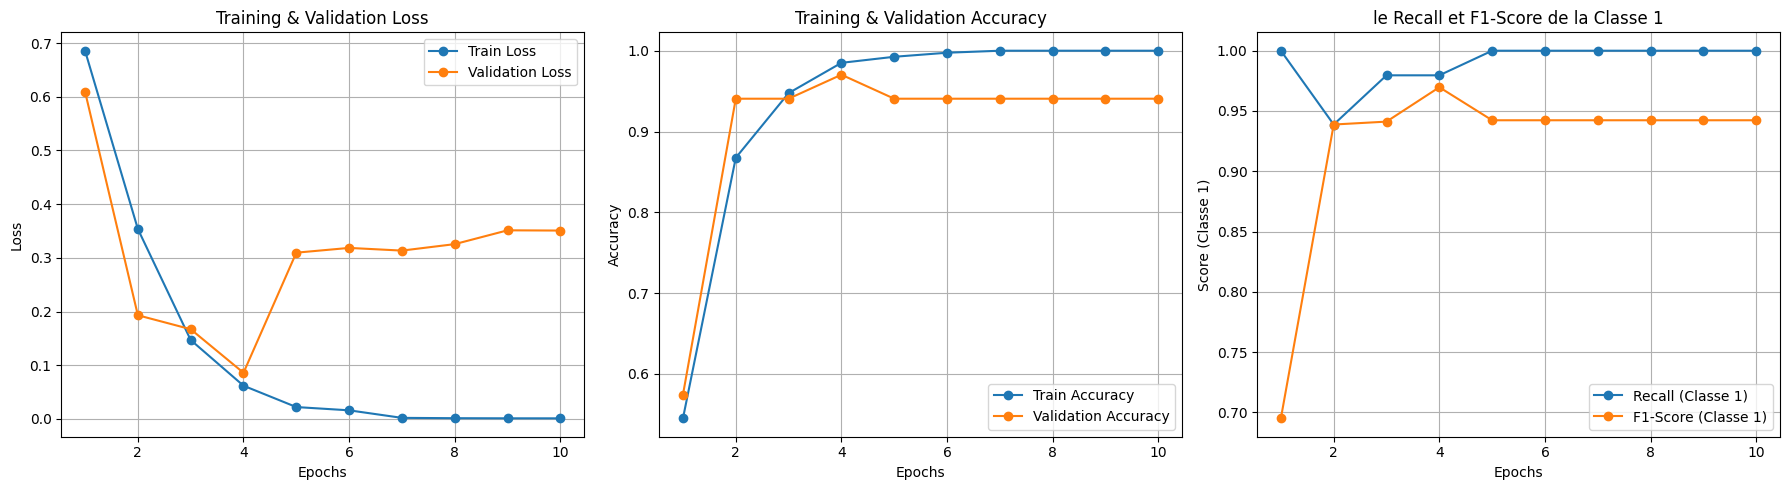

In [50]:

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs_range, history['train_loss'], 'o-', label='Train Loss')
plt.plot(epochs_range, history['val_loss'], 'o-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(epochs_range, history['train_acc'], 'o-', label='Train Accuracy')
plt.plot(epochs_range, history['val_acc'], 'o-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(epochs_range, history['val_recall_minority'],'o-',  label='Recall (Classe 1)')

plt.plot(epochs_range, history['val_f1_minority'],'o-', label='F1-Score (Classe 1)')
plt.xlabel('Epochs')
plt.ylabel('Score (Classe 1)')
plt.title('le Recall et F1-Score de la Classe 1')
plt.legend()
plt.grid(True)

plt.tight_layout() 
plt.show()


--- Évaluation à l'époque 9 ---


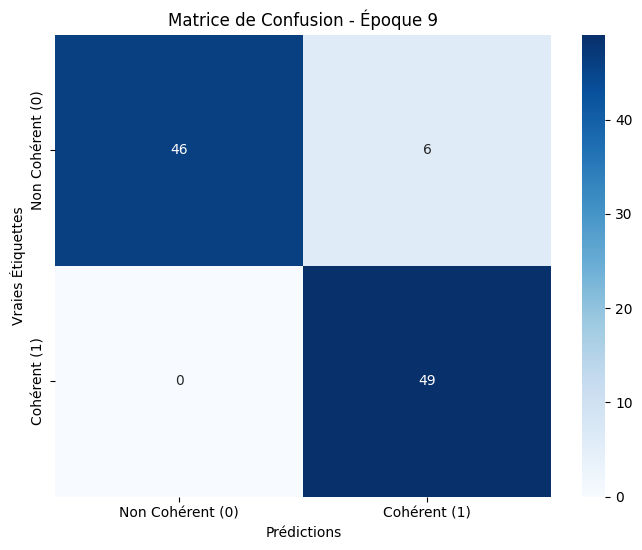

In [51]:

epoch_to_inspect = 9

true_labels, pred_labels = epoch_metrics[epoch_to_inspect]


print(f"\n--- Évaluation à l'époque {epoch_to_inspect} ---")
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Cohérent (0)', 'Cohérent (1)'], yticklabels=['Non Cohérent (0)', 'Cohérent (1)'])
plt.xlabel('Prédictions')
plt.ylabel('Vraies Étiquettes')
plt.title(f'Matrice de Confusion - Époque {epoch_to_inspect}')
plt.show()

# Focal loss (alpha=0.33 betha=2)

In [59]:
BATCH_SIZE = 8
MAX_LEN = 90
#class_weights_sample = 1. / class_counts
class_weights_sample = [1, 2]

LEARNING_RATE = 2e-5
ADAM_EPSILON = 1e-8
EPOCHS = 10

criterion = FocalLoss(alpha=sample_weights_tensor, gamma=2)

In [60]:

if LANGUAGE == "en":
    MODEL_NAME = "distilbert-base-uncased" # Or "roberta-base", "bert-base-uncased", etc.
elif LANGUAGE == "fr":
    MODEL_NAME = "camembert-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class QACoherenceDataset(Dataset):
    def __init__(self, questions, answers, labels, tokenizer, max_len):
        self.questions = questions
        self.answers = answers
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, item):
        question = str(self.questions[item])
        answer = str(self.answers[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            question,
            answer,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

X_questions_train, X_questions_test, \
X_answers_train, X_answers_test, \
y_train, y_test = train_test_split(
    df['cleaned_question'],
    df['cleaned_answer'],
    df['label'],
    test_size=0.2,
    random_state=25,
    stratify=df['label']
)


train_dataset = QACoherenceDataset(
    questions=X_questions_train.values,
    answers=X_answers_train.values,
    labels=y_train.values, 
    tokenizer=tokenizer,
    max_len=MAX_LEN
)
test_dataset = QACoherenceDataset(
    questions=X_questions_test.values,
    answers=X_answers_test.values,
    labels=y_test.values, 
    tokenizer=tokenizer,
    max_len=MAX_LEN
)


if isinstance(y_train, pd.Series):
    y_train_numpy = y_train.values
else:
    y_train_numpy = y_train # Si c'est déjà un array numpy

class_counts = np.bincount(y_train_numpy)
print(f"Comptes des classes dans l'ensemble d'entraînement : {class_counts}")


print(f"Poids inverses des fréquences des classes : {class_weights_sample}")

sample_weights = np.array([class_weights_sample[label] for label in y_train_numpy])
sample_weights_tensor = torch.from_numpy(sample_weights).double()

sampler = WeightedRandomSampler(
    weights=sample_weights_tensor,
    num_samples=len(sample_weights_tensor),
    replacement=True
)


train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler
)


test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE
)




c:\Simoh\Github\BERT_Response_Validity_Checker\.venv\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Comptes des classes dans l'ensemble d'entraînement : [206 194]
Poids inverses des fréquences des classes : [1, 2]


In [61]:

# --- 3. Définir le Modèle, l'Optimiseur, le Scheduler ---

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUtilisation du device: {device}")

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model = model.to(device)


optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=ADAM_EPSILON)
total_steps = len(train_loader) * EPOCHS
num_warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=total_steps
)



Utilisation du device: cpu


c:\Simoh\Github\BERT_Response_Validity_Checker\.venv\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [62]:
# --- 4. Fonctions d'Entraînement et d'Évaluation ---

def train_epoch_fn(model, data_loader, criterion, optimizer, scheduler, device, n_examples): # Ajout de criterion
    model.train()
    total_loss = 0
    correct_predictions = 0
    for batch_idx, batch in enumerate(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        
        # Obtenir les logits SANS calculer la perte dans le modèle
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            # On ne passe plus 'labels' ici
        )
        logits = outputs.logits
        
        # Calculer la perte avec notre fonction custom
        loss = criterion(logits, labels)
        
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
    return correct_predictions.double() / n_examples, total_loss / len(data_loader)

def eval_model_fn(model, data_loader, criterion, device, n_examples): # Ajout de criterion
    model.eval()
    total_eval_loss = 0
    correct_predictions = 0
    all_true_labels = []
    all_pred_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            # Obtenir les logits
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            logits = outputs.logits
            
            # Calculer la perte avec la même fonction pour la comparaison
            loss = criterion(logits, labels)
            
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            total_eval_loss += loss.item()
            
            all_true_labels.extend(labels.cpu().numpy())
            all_pred_labels.extend(preds.cpu().numpy())
            
    avg_loss = total_eval_loss / len(data_loader)
    accuracy = correct_predictions.double() / n_examples
    
    return accuracy, avg_loss, all_true_labels, all_pred_labels

In [63]:

# --- 5. Boucle d'Entraînement ---
# On va utiliser la nouvelle logique de sauvegarde (recall puis F1)
best_val_recall_minority = 0
best_val_f1_minority = 0 
history1 = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 
    'val_recall_minority': [], 'val_f1_minority': []
}

epoch_metrics = {}

for epoch in range(EPOCHS):
    print(f'--- Epoch {epoch + 1}/{EPOCHS} ---')
    # Passer 'criterion' à la fonction d'entraînement
    train_acc, train_loss = train_epoch_fn(
        model, train_loader, criterion, optimizer, scheduler, device, len(train_dataset)
    )
    history1['train_loss'].append(train_loss)
    history1['train_acc'].append(train_acc.item())
    print(f'  Train loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}')

    # Passer 'criterion' à la fonction d'évaluation
    val_acc, val_loss, val_true, val_pred = eval_model_fn(
        model, test_loader, criterion, device, len(test_dataset)
    )
    history1['val_loss'].append(val_loss)
    history1['val_acc'].append(val_acc.item())
    epoch_metrics[epoch] = (val_true, val_pred)
    # Le reste de la boucle pour le calcul des métriques et la sauvegarde est identique
    # à la version précédente que nous avions développée.
    
    val_recall_class1 = recall_score(val_true, val_pred, pos_label=1, zero_division=0)
    val_f1_class1 = f1_score(val_true, val_pred, pos_label=1, zero_division=0)
    history1['val_recall_minority'].append(val_recall_class1)
    history1['val_f1_minority'].append(val_f1_class1)

    print(f'  Val. loss: {val_loss:.4f} | Val. Acc: {val_acc:.4f} | Val. Recall (Cl. 1): {val_recall_class1:.4f} | Val. F1 (Cl. 1): {val_f1_class1:.4f}')

    save_condition = (val_recall_class1 > best_val_recall_minority) or \
                     (val_recall_class1 == best_val_recall_minority and val_f1_class1 > best_val_f1_minority)

    if save_condition:
        best_val_recall_minority = val_recall_class1
        
        best_val_f1_minority = val_f1_class1
        print(f"  >> Nouveau meilleur modèle sauvegardé ! Recall: {best_val_recall_minority:.4f}, F1: {best_val_f1_minority:.4f}")
        # torch.save(model.state_dict(), 'best_model_focal_loss.bin')

--- Epoch 1/10 ---
  Train loss: 0.2406 | Train Accuracy: 0.5675
  Val. loss: 0.2403 | Val. Acc: 0.5743 | Val. Recall (Cl. 1): 1.0000 | Val. F1 (Cl. 1): 0.6950
  >> Nouveau meilleur modèle sauvegardé ! Recall: 1.0000, F1: 0.6950
--- Epoch 2/10 ---
  Train loss: 0.0909 | Train Accuracy: 0.8650
  Val. loss: 0.0479 | Val. Acc: 0.9406 | Val. Recall (Cl. 1): 0.9796 | Val. F1 (Cl. 1): 0.9412
--- Epoch 3/10 ---
  Train loss: 0.0218 | Train Accuracy: 0.9800
  Val. loss: 0.0844 | Val. Acc: 0.9307 | Val. Recall (Cl. 1): 0.9592 | Val. F1 (Cl. 1): 0.9307
--- Epoch 4/10 ---
  Train loss: 0.0175 | Train Accuracy: 0.9850
  Val. loss: 0.0968 | Val. Acc: 0.9406 | Val. Recall (Cl. 1): 1.0000 | Val. F1 (Cl. 1): 0.9423
  >> Nouveau meilleur modèle sauvegardé ! Recall: 1.0000, F1: 0.9423
--- Epoch 5/10 ---


KeyboardInterrupt: 

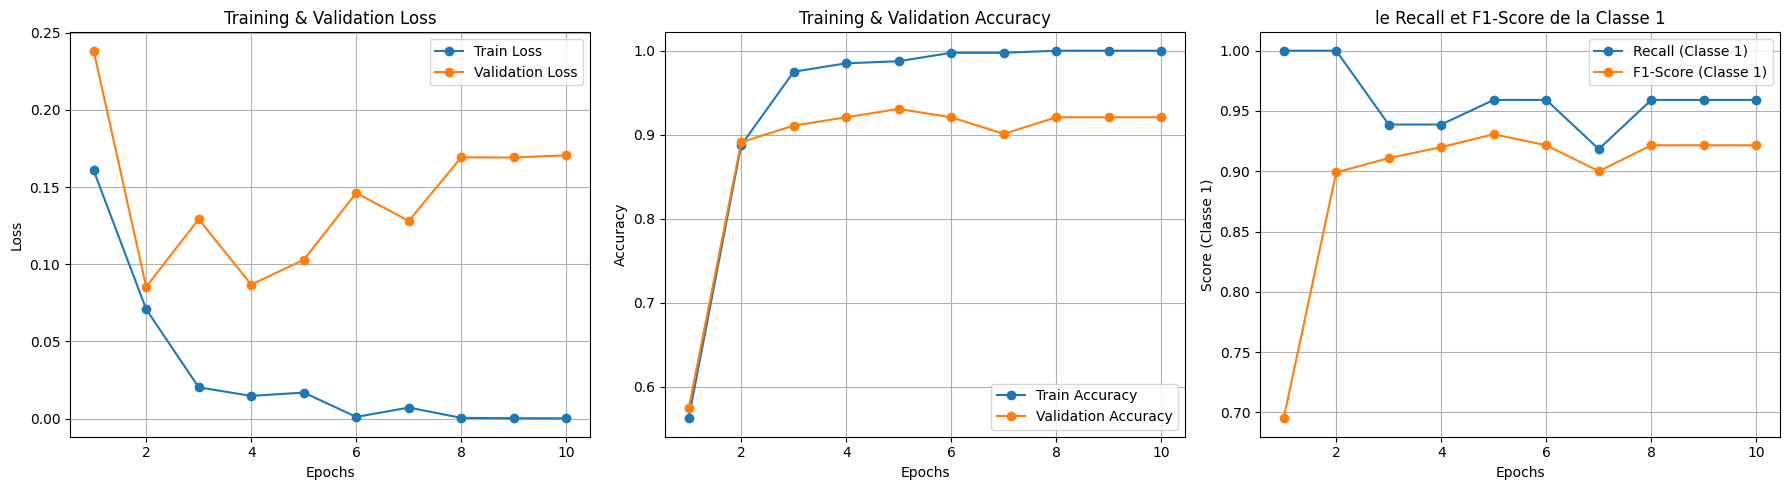

In [ ]:
# --- 6. Visualisation des Courbes ---

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(18, 5))

# Plot 1: Loss (Training vs. Validation)
plt.subplot(1, 3, 1)
plt.plot(epochs_range, history1['train_loss'], 'o-', label='Train Loss')
plt.plot(epochs_range, history1['val_loss'], 'o-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy (Training vs. Validation)
plt.subplot(1, 3, 2)
plt.plot(epochs_range, history1['train_acc'], 'o-', label='Train Accuracy')
plt.plot(epochs_range, history1['val_acc'], 'o-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid(True)

# Plot 3: Validation F1-score (Minority Class)
plt.subplot(1, 3, 3)
plt.plot(epochs_range, history1['val_recall_minority'],'o-',  label='Recall (Classe 1)')

plt.plot(epochs_range, history1['val_f1_minority'],'o-', label='F1-Score (Classe 1)')
plt.xlabel('Epochs')
plt.ylabel('Score (Classe 1)')
plt.title('le Recall et F1-Score de la Classe 1')
plt.legend()
plt.grid(True)

plt.tight_layout() # Ajuste automatiquement les subplots pour qu'ils ne se chevauchent pas
plt.show()


--- Évaluation à l'époque 9 ---


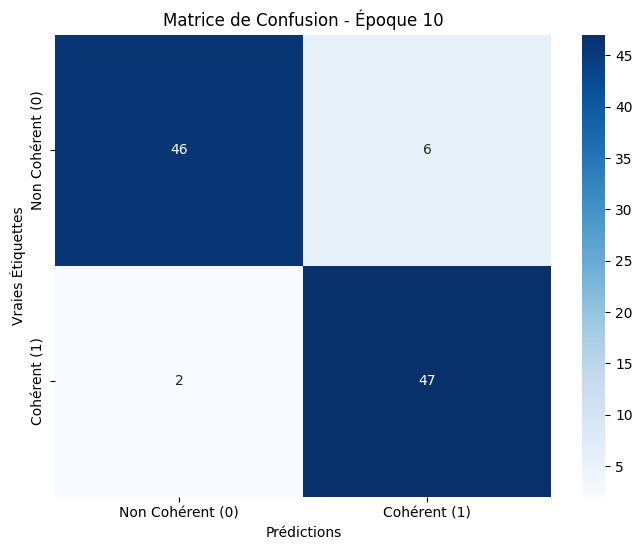

In [58]:
# --- 6. Évaluation à une époque spécifique ---
epoch_to_inspect = 9

true_labels, pred_labels = epoch_metrics[epoch_to_inspect]

# Calcule et affiche les métriques comme avant
print(f"\n--- Évaluation à l'époque {epoch_to_inspect} ---")
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Cohérent (0)', 'Cohérent (1)'], yticklabels=['Non Cohérent (0)', 'Cohérent (1)'])
plt.xlabel('Prédictions')
plt.ylabel('Vraies Étiquettes')
plt.title(f'Matrice de Confusion - Époque {epoch_to_inspect+1}')
plt.show()

# Focal loss (alpha=0.25 betha=2)

In [23]:
BATCH_SIZE = 8
MAX_LEN = 90
#class_weights_sample = 1. / class_counts
class_weights_sample = [1, 4]

LEARNING_RATE = 2e-5
ADAM_EPSILON = 1e-8
EPOCHS = 10

criterion = FocalLoss(alpha=sample_weights_tensor, gamma=2)

In [24]:

# --- 2. Préparer les Données pour CamemBERT ---
#MODEL_NAME = "bert-base-uncased"

if LANGUAGE == "en":
    MODEL_NAME = "distilbert-base-uncased" # Or "roberta-base", "distilbert-base-uncased", etc.
elif LANGUAGE == "fr":
    MODEL_NAME = "camembert-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class QACoherenceDataset(Dataset):
    def __init__(self, questions, answers, labels, tokenizer, max_len):
        self.questions = questions
        self.answers = answers
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, item):
        question = str(self.questions[item])
        answer = str(self.answers[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            question,
            answer,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

X_questions_train, X_questions_test, \
X_answers_train, X_answers_test, \
y_train, y_test = train_test_split(
    df['cleaned_question'],
    df['cleaned_answer'],
    df['label'],
    test_size=0.2,
    random_state=25,
    stratify=df['label']
)


train_dataset = QACoherenceDataset(
    questions=X_questions_train.values,
    answers=X_answers_train.values,
    labels=y_train.values, 
    tokenizer=tokenizer,
    max_len=MAX_LEN
)
test_dataset = QACoherenceDataset(
    questions=X_questions_test.values,
    answers=X_answers_test.values,
    labels=y_test.values, 
    tokenizer=tokenizer,
    max_len=MAX_LEN
)


if isinstance(y_train, pd.Series):
    y_train_numpy = y_train.values
else:
    y_train_numpy = y_train # Si c'est déjà un array numpy

class_counts = np.bincount(y_train_numpy)
print(f"Comptes des classes dans l'ensemble d'entraînement : {class_counts}")


print(f"Poids inverses des fréquences des classes : {class_weights_sample}")

sample_weights = np.array([class_weights_sample[label] for label in y_train_numpy])
sample_weights_tensor = torch.from_numpy(sample_weights).double()

sampler = WeightedRandomSampler(
    weights=sample_weights_tensor,
    num_samples=len(sample_weights_tensor),
    replacement=True
)


train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler
)


test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE
)




c:\Simoh\Github\BERT_Response_Validity_Checker\.venv\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Comptes des classes dans l'ensemble d'entraînement : [206 194]
Poids inverses des fréquences des classes : [1, 4]


In [25]:

# --- 3. Définir le Modèle, l'Optimiseur, le Scheduler ---

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUtilisation du device: {device}")

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model = model.to(device)


optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=ADAM_EPSILON)
total_steps = len(train_loader) * EPOCHS
num_warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=total_steps
)



Utilisation du device: cpu


c:\Simoh\Github\BERT_Response_Validity_Checker\.venv\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
# --- 4. Fonctions d'Entraînement et d'Évaluation ---

def train_epoch_fn(model, data_loader, criterion, optimizer, scheduler, device, n_examples): # Ajout de criterion
    model.train()
    total_loss = 0
    correct_predictions = 0
    for batch_idx, batch in enumerate(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        
        # Obtenir les logits SANS calculer la perte dans le modèle
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            # On ne passe plus 'labels' ici
        )
        logits = outputs.logits
        
        # Calculer la perte avec notre fonction custom
        loss = criterion(logits, labels)
        
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
    return correct_predictions.double() / n_examples, total_loss / len(data_loader)

def eval_model_fn(model, data_loader, criterion, device, n_examples): # Ajout de criterion
    model.eval()
    total_eval_loss = 0
    correct_predictions = 0
    all_true_labels = []
    all_pred_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            # Obtenir les logits
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            logits = outputs.logits
            
            # Calculer la perte avec la même fonction pour la comparaison
            loss = criterion(logits, labels)
            
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            total_eval_loss += loss.item()
            
            all_true_labels.extend(labels.cpu().numpy())
            all_pred_labels.extend(preds.cpu().numpy())
            
    avg_loss = total_eval_loss / len(data_loader)
    accuracy = correct_predictions.double() / n_examples
    
    return accuracy, avg_loss, all_true_labels, all_pred_labels

In [27]:

# --- 5. Boucle d'Entraînement ---
# On va utiliser la nouvelle logique de sauvegarde (recall puis F1)
best_val_recall_minority = 0
best_val_f1_minority = 0 
history2 = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 
    'val_recall_minority': [], 'val_f1_minority': []
}

epoch_metrics = {}

for epoch in range(EPOCHS):
    print(f'--- Epoch {epoch + 1}/{EPOCHS} ---')
    # Passer 'criterion' à la fonction d'entraînement
    train_acc, train_loss = train_epoch_fn(
        model, train_loader, criterion, optimizer, scheduler, device, len(train_dataset)
    )
    history2['train_loss'].append(train_loss)
    history2['train_acc'].append(train_acc.item())
    print(f'  Train loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}')

    # Passer 'criterion' à la fonction d'évaluation
    val_acc, val_loss, val_true, val_pred = eval_model_fn(
        model, test_loader, criterion, device, len(test_dataset)
    )
    history2['val_loss'].append(val_loss)
    history2['val_acc'].append(val_acc.item())
    epoch_metrics[epoch] = (val_true, val_pred)
    # Le reste de la boucle pour le calcul des métriques et la sauvegarde est identique
    # à la version précédente que nous avions développée.
    
    val_recall_class1 = recall_score(val_true, val_pred, pos_label=1, zero_division=0)
    val_f1_class1 = f1_score(val_true, val_pred, pos_label=1, zero_division=0)
    history2['val_recall_minority'].append(val_recall_class1)
    history2['val_f1_minority'].append(val_f1_class1)

    print(f'  Val. loss: {val_loss:.4f} | Val. Acc: {val_acc:.4f} | Val. Recall (Cl. 1): {val_recall_class1:.4f} | Val. F1 (Cl. 1): {val_f1_class1:.4f}')

    save_condition = (val_recall_class1 > best_val_recall_minority) or \
                     (val_recall_class1 == best_val_recall_minority and val_f1_class1 > best_val_f1_minority)

    if save_condition:
        best_val_recall_minority = val_recall_class1
        
        best_val_f1_minority = val_f1_class1
        print(f"  >> Nouveau meilleur modèle sauvegardé ! Recall: {best_val_recall_minority:.4f}, F1: {best_val_f1_minority:.4f}")
        # torch.save(model.state_dict(), 'best_model_focal_loss.bin')

--- Epoch 1/10 ---
  Train loss: 0.1948 | Train Accuracy: 0.7975
  Val. loss: 0.2875 | Val. Acc: 0.4851 | Val. Recall (Cl. 1): 1.0000 | Val. F1 (Cl. 1): 0.6533
  >> Nouveau meilleur modèle sauvegardé ! Recall: 1.0000, F1: 0.6533
--- Epoch 2/10 ---
  Train loss: 0.0627 | Train Accuracy: 0.9075
  Val. loss: 0.1112 | Val. Acc: 0.9109 | Val. Recall (Cl. 1): 1.0000 | Val. F1 (Cl. 1): 0.9159
  >> Nouveau meilleur modèle sauvegardé ! Recall: 1.0000, F1: 0.9159
--- Epoch 3/10 ---
  Train loss: 0.0194 | Train Accuracy: 0.9850
  Val. loss: 0.1022 | Val. Acc: 0.9406 | Val. Recall (Cl. 1): 1.0000 | Val. F1 (Cl. 1): 0.9423
  >> Nouveau meilleur modèle sauvegardé ! Recall: 1.0000, F1: 0.9423
--- Epoch 4/10 ---
  Train loss: 0.0105 | Train Accuracy: 0.9950
  Val. loss: 0.0849 | Val. Acc: 0.9406 | Val. Recall (Cl. 1): 0.9796 | Val. F1 (Cl. 1): 0.9412
--- Epoch 5/10 ---
  Train loss: 0.0059 | Train Accuracy: 0.9925
  Val. loss: 0.1078 | Val. Acc: 0.9406 | Val. Recall (Cl. 1): 0.9796 | Val. F1 (Cl. 1): 

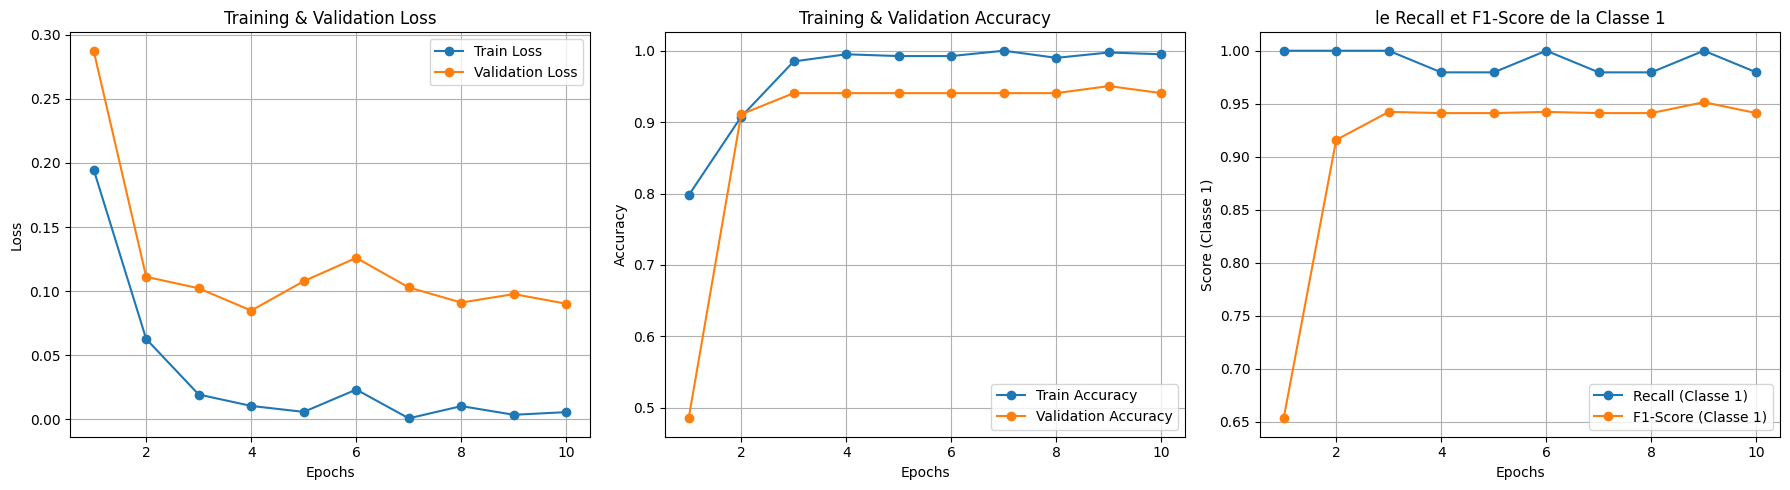

In [28]:
# --- 6. Visualisation des Courbes ---

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(18, 5))

# Plot 1: Loss (Training vs. Validation)
plt.subplot(1, 3, 1)
plt.plot(epochs_range, history2['train_loss'], 'o-', label='Train Loss')
plt.plot(epochs_range, history2['val_loss'], 'o-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy (Training vs. Validation)
plt.subplot(1, 3, 2)
plt.plot(epochs_range, history2['train_acc'], 'o-', label='Train Accuracy')
plt.plot(epochs_range, history2['val_acc'], 'o-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid(True)

# Plot 3: Validation F1-score (Minority Class)
plt.subplot(1, 3, 3)
plt.plot(epochs_range, history2['val_recall_minority'],'o-',  label='Recall (Classe 1)')

plt.plot(epochs_range, history2['val_f1_minority'],'o-', label='F1-Score (Classe 1)')
plt.xlabel('Epochs')
plt.ylabel('Score (Classe 1)')
plt.title('le Recall et F1-Score de la Classe 1')
plt.legend()
plt.grid(True)

plt.tight_layout() # Ajuste automatiquement les subplots pour qu'ils ne se chevauchent pas
plt.show()


--- Évaluation à l'époque 9 ---


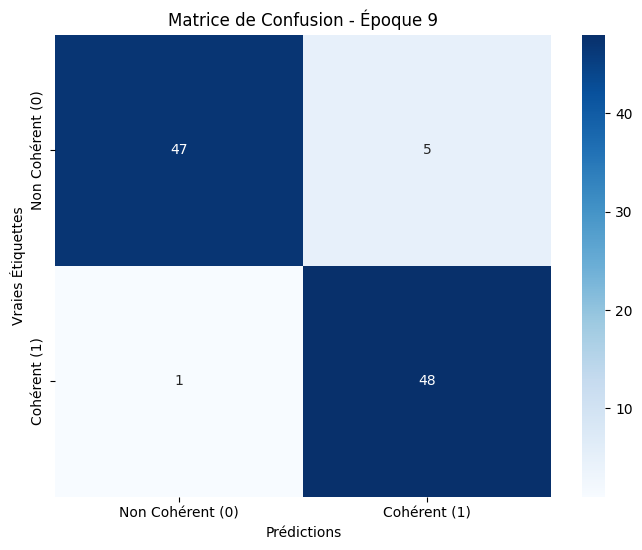

In [29]:
# --- 6. Évaluation à une époque spécifique ---
epoch_to_inspect = 9

true_labels, pred_labels = epoch_metrics[epoch_to_inspect]

# Calcule et affiche les métriques comme avant
print(f"\n--- Évaluation à l'époque {epoch_to_inspect} ---")
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Cohérent (0)', 'Cohérent (1)'], yticklabels=['Non Cohérent (0)', 'Cohérent (1)'])
plt.xlabel('Prédictions')
plt.ylabel('Vraies Étiquettes')
plt.title(f'Matrice de Confusion - Époque {epoch_to_inspect}')
plt.show()

# K fold

In [64]:
BATCH_SIZE = 8
MAX_LEN = 90
#class_weights_sample = 1. / class_counts
class_weights_sample = [1, 1]

LEARNING_RATE = 2e-5
ADAM_EPSILON = 1e-8
EPOCHS = 10

#criterion = FocalLoss(alpha=sample_weights_tensor, gamma=2)

In [ ]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [68]:
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt

cv_history = []   # historique complet par fold
all_fold_f1 = []  # meilleurs F1 par fold
all_fold_recall = []  # meilleurs recall par fold

for fold, (train_idx, val_idx) in enumerate(kf.split(df[['cleaned_question', 'cleaned_answer']], df['label'])):
    print(f"\n=== Fold {fold+1} / {kf.get_n_splits()} ===")

    # Séparer train/val
    train_questions = df.iloc[train_idx]['cleaned_question'].values
    train_answers   = df.iloc[train_idx]['cleaned_answer'].values
    train_labels    = df.iloc[train_idx]['label'].values
    
    val_questions = df.iloc[val_idx]['cleaned_question'].values
    val_answers   = df.iloc[val_idx]['cleaned_answer'].values
    val_labels    = df.iloc[val_idx]['label'].values

    # Construire datasets
    train_dataset = QACoherenceDataset(train_questions, train_answers, train_labels, tokenizer, MAX_LEN)
    val_dataset   = QACoherenceDataset(val_questions, val_answers, val_labels, tokenizer, MAX_LEN)

    # Sampler pondéré
    class_counts = np.bincount(train_labels)
    class_weights_sample = [1,1]  # à remplacer si tu veux pondérer
    sample_weights = np.array([class_weights_sample[label] for label in train_labels])
    sampler = WeightedRandomSampler(weights=torch.from_numpy(sample_weights).double(),
                                    num_samples=len(sample_weights),
                                    replacement=True)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
    val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    # Réinitialiser le modèle à chaque fold
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(device)
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=ADAM_EPSILON)
    total_steps = len(train_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps=int(0.1 * total_steps),
                                                num_training_steps=total_steps)

    # Entraînement
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 
               'val_acc': [], 'val_f1': [], 'val_recall': []}
    
    best_val_f1 = 0
    best_val_recall = 0

    for epoch in range(EPOCHS):
        train_acc, train_loss = train_epoch_fn(model, train_loader, optimizer, scheduler, device, len(train_dataset))
        val_acc, val_loss, val_true, val_pred = eval_model_fn(model, val_loader, device, len(val_dataset))

        val_f1 = f1_score(val_true, val_pred, pos_label=1)
        val_recall = recall_score(val_true, val_pred, pos_label=1)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc.item())
        history['val_acc'].append(val_acc.item())
        history['val_f1'].append(val_f1)
        history['val_recall'].append(val_recall)

        print(f"Epoch {epoch+1}: Train acc {train_acc:.3f}, "
              f"Val acc {val_acc:.3f}, Val Recall {val_recall:.3f}, Val F1 {val_f1:.3f}")
        
        save_condition = (val_recall > best_val_recall) or \
                        (val_recall == best_val_recall and val_f1 > best_val_f1)

        if save_condition:
            best_val_recall = val_recall
            best_val_f1 = val_f1

    cv_history.append(history)
    all_fold_f1.append(best_val_f1)
    all_fold_recall.append(best_val_recall)



=== Fold 1 / 5 ===


c:\Simoh\Github\BERT_Response_Validity_Checker\.venv\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: Train acc 0.585, Val acc 0.812, Val F1 0.812
Epoch 2: Train acc 0.922, Val acc 0.921, Val F1 0.911
Epoch 3: Train acc 0.978, Val acc 0.921, Val F1 0.915
Epoch 4: Train acc 1.000, Val acc 0.931, Val F1 0.926
Epoch 5: Train acc 1.000, Val acc 0.941, Val F1 0.938
Epoch 6: Train acc 1.000, Val acc 0.931, Val F1 0.926
Epoch 7: Train acc 1.000, Val acc 0.941, Val F1 0.936
Epoch 8: Train acc 1.000, Val acc 0.941, Val F1 0.938
Epoch 9: Train acc 1.000, Val acc 0.941, Val F1 0.938
Epoch 10: Train acc 1.000, Val acc 0.941, Val F1 0.938

=== Fold 2 / 5 ===


c:\Simoh\Github\BERT_Response_Validity_Checker\.venv\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: Train acc 0.556, Val acc 0.800, Val F1 0.825
Epoch 2: Train acc 0.905, Val acc 0.940, Val F1 0.938
Epoch 3: Train acc 0.963, Val acc 0.950, Val F1 0.948
Epoch 4: Train acc 0.988, Val acc 0.940, Val F1 0.939
Epoch 5: Train acc 0.995, Val acc 0.940, Val F1 0.941
Epoch 6: Train acc 0.990, Val acc 0.940, Val F1 0.940
Epoch 7: Train acc 0.998, Val acc 0.920, Val F1 0.920
Epoch 8: Train acc 0.998, Val acc 0.930, Val F1 0.929
Epoch 9: Train acc 1.000, Val acc 0.930, Val F1 0.929
Epoch 10: Train acc 1.000, Val acc 0.930, Val F1 0.929

=== Fold 3 / 5 ===


c:\Simoh\Github\BERT_Response_Validity_Checker\.venv\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: Train acc 0.579, Val acc 0.690, Val F1 0.756
Epoch 2: Train acc 0.870, Val acc 0.930, Val F1 0.932
Epoch 3: Train acc 0.955, Val acc 0.980, Val F1 0.979
Epoch 4: Train acc 0.988, Val acc 0.980, Val F1 0.979
Epoch 5: Train acc 0.993, Val acc 0.980, Val F1 0.979
Epoch 6: Train acc 0.993, Val acc 0.990, Val F1 0.990
Epoch 7: Train acc 0.995, Val acc 0.980, Val F1 0.979
Epoch 8: Train acc 0.998, Val acc 0.990, Val F1 0.990
Epoch 9: Train acc 1.000, Val acc 0.990, Val F1 0.989


c:\Simoh\Github\BERT_Response_Validity_Checker\.venv\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 10: Train acc 1.000, Val acc 0.990, Val F1 0.990

=== Fold 4 / 5 ===
Epoch 1: Train acc 0.594, Val acc 0.680, Val F1 0.754
Epoch 2: Train acc 0.880, Val acc 0.920, Val F1 0.925
Epoch 3: Train acc 0.978, Val acc 0.950, Val F1 0.951
Epoch 4: Train acc 0.983, Val acc 0.940, Val F1 0.941
Epoch 5: Train acc 0.995, Val acc 0.940, Val F1 0.942
Epoch 6: Train acc 0.993, Val acc 0.930, Val F1 0.929
Epoch 7: Train acc 1.000, Val acc 0.930, Val F1 0.929
Epoch 8: Train acc 0.998, Val acc 0.930, Val F1 0.929
Epoch 9: Train acc 0.998, Val acc 0.950, Val F1 0.951


c:\Simoh\Github\BERT_Response_Validity_Checker\.venv\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 10: Train acc 1.000, Val acc 0.950, Val F1 0.951

=== Fold 5 / 5 ===
Epoch 1: Train acc 0.628, Val acc 0.690, Val F1 0.760
Epoch 2: Train acc 0.925, Val acc 0.980, Val F1 0.980
Epoch 3: Train acc 0.975, Val acc 0.940, Val F1 0.942
Epoch 4: Train acc 0.988, Val acc 0.950, Val F1 0.949
Epoch 5: Train acc 0.980, Val acc 0.980, Val F1 0.980
Epoch 6: Train acc 0.995, Val acc 0.970, Val F1 0.970
Epoch 7: Train acc 0.998, Val acc 0.950, Val F1 0.951
Epoch 8: Train acc 0.998, Val acc 0.950, Val F1 0.951
Epoch 9: Train acc 0.998, Val acc 0.950, Val F1 0.951
Epoch 10: Train acc 1.000, Val acc 0.950, Val F1 0.951


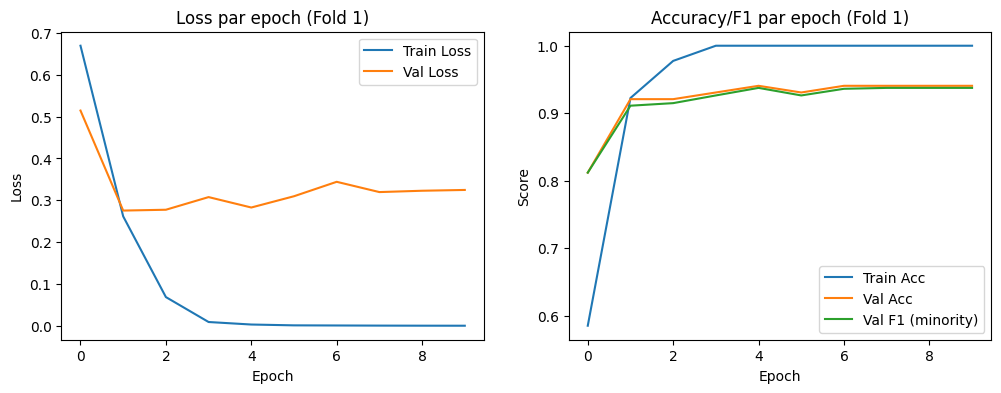

In [70]:
fold0 = cv_history[0]

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(fold0['train_loss'], label="Train Loss")
plt.plot(fold0['val_loss'], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss par epoch (Fold 1)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(fold0['train_acc'], label="Train Acc")
plt.plot(fold0['val_acc'], label="Val Acc")
plt.plot(fold0['val_f1'], label="Val F1 (minority)")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Accuracy/F1 par epoch (Fold 1)")
plt.legend()
plt.show()


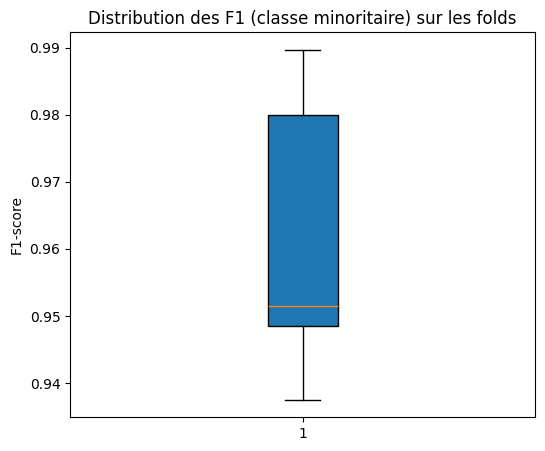

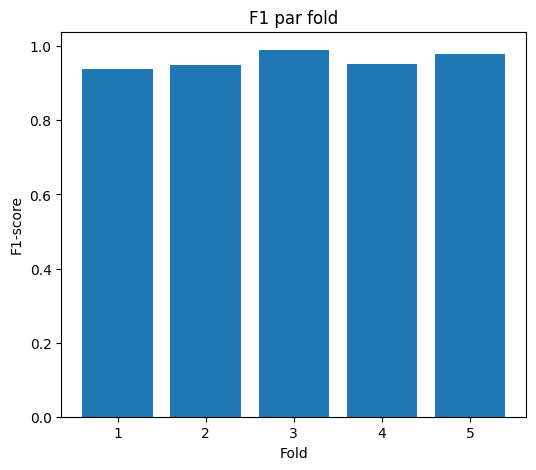

In [71]:
plt.figure(figsize=(6,5))
plt.boxplot(all_fold_f1, vert=True, patch_artist=True)
plt.title("Distribution des F1 (classe minoritaire) sur les folds")
plt.ylabel("F1-score")
plt.show()

plt.figure(figsize=(6,5))
plt.bar(range(1, len(all_fold_f1)+1), all_fold_f1)
plt.title("F1 par fold")
plt.xlabel("Fold")
plt.ylabel("F1-score")
plt.show()


In [ ]:

# --- 3. Définir le Modèle, l'Optimiseur, le Scheduler ---

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUtilisation du device: {device}")

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model = model.to(device)


optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=ADAM_EPSILON)
total_steps = len(train_loader) * EPOCHS
num_warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=total_steps
)


In [67]:

def train_epoch_fn(model, data_loader, optimizer, scheduler, device, n_examples):
    model.train()
    total_loss = 0
    correct_predictions = 0
    for batch_idx, batch in enumerate(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
    return correct_predictions.double() / n_examples, total_loss / len(data_loader)

def eval_model_fn(model, data_loader, device, n_examples):
    model.eval()
    total_eval_loss = 0
    correct_predictions = 0
    all_true_labels = []
    all_pred_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            total_eval_loss += loss.item()
            all_true_labels.extend(labels.cpu().numpy())
            all_pred_labels.extend(preds.cpu().numpy())
    avg_loss = total_eval_loss / len(data_loader)
    accuracy = correct_predictions.double() / n_examples
    return accuracy, avg_loss, all_true_labels, all_pred_labels



In [ ]:

best_val_recall_minority = 0
best_val_f1_minority = 0 
history = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 
    'val_recall_minority': [], 'val_f1_minority': []
}

epoch_metrics = {}

for epoch in range(EPOCHS):
    print(f'--- Epoch {epoch + 1}/{EPOCHS} ---')
    
    train_acc, train_loss = train_epoch_fn(
        model, train_loader, optimizer, scheduler, device, len(train_dataset)
    )
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc.item())
    print(f'  Train loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}')



    val_acc, val_loss, val_true, val_pred = eval_model_fn(
        model, test_loader, device, len(test_dataset)
    )
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc.item())
    epoch_metrics[epoch] = (val_true, val_pred)
    
    
    
    val_recall_class1 = recall_score(val_true, val_pred, pos_label=1, zero_division=0)
    val_f1_class1 = f1_score(val_true, val_pred, pos_label=1, zero_division=0)
    history['val_recall_minority'].append(val_recall_class1)
    history['val_f1_minority'].append(val_f1_class1)

    print(f'  Val. loss: {val_loss:.4f} | Val. Acc: {val_acc:.4f} | Val. Recall (Cl. 1): {val_recall_class1:.4f} | Val. F1 (Cl. 1): {val_f1_class1:.4f}')

    save_condition = (val_recall_class1 > best_val_recall_minority) or \
                     (val_recall_class1 == best_val_recall_minority and val_f1_class1 > best_val_f1_minority)

    if save_condition:
        best_val_recall_minority = val_recall_class1
        
        best_val_f1_minority = val_f1_class1
        print(f"  >> Nouveau meilleur modèle sauvegardé ! Recall: {best_val_recall_minority:.4f}, F1: {best_val_f1_minority:.4f}")
        # torch.save(model.state_dict(), 'best_model_focal_loss.bin')

# Autre

In [ ]:

# --- 2. Préparer les Données pour CamemBERT ---
#MODEL_NAME = "bert-base-uncased"

if LANGUAGE == "en":
    MODEL_NAME = "distilbert-base-uncased" # Or "roberta-base", "distilbert-base-uncased", etc.
elif LANGUAGE == "fr":
    MODEL_NAME = "camembert-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class QACoherenceDataset(Dataset):
    def __init__(self, questions, answers, labels, tokenizer, max_len):
        self.questions = questions
        self.answers = answers
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, item):
        question = str(self.questions[item])
        answer = str(self.answers[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            question,
            answer,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

X_questions_train, X_questions_test, \
X_answers_train, X_answers_test, \
y_train, y_test = train_test_split(
    df['cleaned_question'],
    df['cleaned_answer'],
    df['label'],
    test_size=0.2,
    random_state=25,
    stratify=df['label']
)


train_dataset = QACoherenceDataset(
    questions=X_questions_train.values,
    answers=X_answers_train.values,
    labels=y_train.values, 
    tokenizer=tokenizer,
    max_len=MAX_LEN
)
test_dataset = QACoherenceDataset(
    questions=X_questions_test.values,
    answers=X_answers_test.values,
    labels=y_test.values, 
    tokenizer=tokenizer,
    max_len=MAX_LEN
)


if isinstance(y_train, pd.Series):
    y_train_numpy = y_train.values
else:
    y_train_numpy = y_train # Si c'est déjà un array numpy

class_counts = np.bincount(y_train_numpy)
print(f"Comptes des classes dans l'ensemble d'entraînement : {class_counts}")


print(f"Poids inverses des fréquences des classes : {class_weights_sample}")

sample_weights = np.array([class_weights_sample[label] for label in y_train_numpy])
sample_weights_tensor = torch.from_numpy(sample_weights).double()

sampler = WeightedRandomSampler(
    weights=sample_weights_tensor,
    num_samples=len(sample_weights_tensor),
    replacement=True
)


train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler
)


test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE
)




Comptes des classes dans l'ensemble d'entraînement : [206 194]
Poids inverses des fréquences des classes : [1, 1]


c:\Simoh\Github\BERT_Response_Validity_Checker\.venv\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:

# --- 3. Définir le Modèle, l'Optimiseur, le Scheduler ---

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUtilisation du device: {device}")

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model = model.to(device)


optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=ADAM_EPSILON)
total_steps = len(train_loader) * EPOCHS
num_warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=total_steps
)


c:\Simoh\Github\BERT_Response_Validity_Checker\.venv\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Utilisation du device: cpu


In [14]:
# --- 4. Fonctions d'Entraînement et d'Évaluation ---

def train_epoch_fn(model, data_loader, criterion, optimizer, scheduler, device, n_examples): # Ajout de criterion
    model.train()
    total_loss = 0
    correct_predictions = 0
    for batch_idx, batch in enumerate(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        
        # Obtenir les logits SANS calculer la perte dans le modèle
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            # On ne passe plus 'labels' ici
        )
        logits = outputs.logits
        
        # Calculer la perte avec notre fonction custom
        loss = criterion(logits, labels)
        
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
    return correct_predictions.double() / n_examples, total_loss / len(data_loader)

def eval_model_fn(model, data_loader, criterion, device, n_examples): # Ajout de criterion
    model.eval()
    total_eval_loss = 0
    correct_predictions = 0
    all_true_labels = []
    all_pred_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            # Obtenir les logits
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            logits = outputs.logits
            
            # Calculer la perte avec la même fonction pour la comparaison
            loss = criterion(logits, labels)
            
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            total_eval_loss += loss.item()
            
            all_true_labels.extend(labels.cpu().numpy())
            all_pred_labels.extend(preds.cpu().numpy())
            
    avg_loss = total_eval_loss / len(data_loader)
    accuracy = correct_predictions.double() / n_examples
    
    return accuracy, avg_loss, all_true_labels, all_pred_labels

In [15]:

# --- 5. Boucle d'Entraînement ---
# On va utiliser la nouvelle logique de sauvegarde (recall puis F1)
best_val_recall_minority = 0
best_val_f1_minority = 0 
history = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 
    'val_recall_minority': [], 'val_f1_minority': []
}

epoch_metrics = {}

for epoch in range(EPOCHS):
    print(f'--- Epoch {epoch + 1}/{EPOCHS} ---')
    # Passer 'criterion' à la fonction d'entraînement
    train_acc, train_loss = train_epoch_fn(
        model, train_loader, criterion, optimizer, scheduler, device, len(train_dataset)
    )
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc.item())
    print(f'  Train loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}')

    # Passer 'criterion' à la fonction d'évaluation
    val_acc, val_loss, val_true, val_pred = eval_model_fn(
        model, test_loader, criterion, device, len(test_dataset)
    )
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc.item())
    epoch_metrics[epoch] = (val_true, val_pred)
    # Le reste de la boucle pour le calcul des métriques et la sauvegarde est identique
    # à la version précédente que nous avions développée.
    
    val_recall_class1 = recall_score(val_true, val_pred, pos_label=1, zero_division=0)
    val_f1_class1 = f1_score(val_true, val_pred, pos_label=1, zero_division=0)
    history['val_recall_minority'].append(val_recall_class1)
    history['val_f1_minority'].append(val_f1_class1)

    print(f'  Val. loss: {val_loss:.4f} | Val. Acc: {val_acc:.4f} | Val. Recall (Cl. 1): {val_recall_class1:.4f} | Val. F1 (Cl. 1): {val_f1_class1:.4f}')

    save_condition = (val_recall_class1 > best_val_recall_minority) or \
                     (val_recall_class1 == best_val_recall_minority and val_f1_class1 > best_val_f1_minority)

    if save_condition:
        best_val_recall_minority = val_recall_class1
        
        best_val_f1_minority = val_f1_class1
        print(f"  >> Nouveau meilleur modèle sauvegardé ! Recall: {best_val_recall_minority:.4f}, F1: {best_val_f1_minority:.4f}")
        # torch.save(model.state_dict(), 'best_model_focal_loss.bin')

--- Epoch 1/10 ---
  Train loss: 0.1595 | Train Accuracy: 0.6575
  Val. loss: 0.1557 | Val. Acc: 0.6139 | Val. Recall (Cl. 1): 1.0000 | Val. F1 (Cl. 1): 0.7153
  >> Nouveau meilleur modèle sauvegardé ! Recall: 1.0000, F1: 0.7153
--- Epoch 2/10 ---
  Train loss: 0.0625 | Train Accuracy: 0.9050
  Val. loss: 0.0322 | Val. Acc: 0.9604 | Val. Recall (Cl. 1): 0.9796 | Val. F1 (Cl. 1): 0.9600
--- Epoch 3/10 ---
  Train loss: 0.0380 | Train Accuracy: 0.9650
  Val. loss: 0.0423 | Val. Acc: 0.9406 | Val. Recall (Cl. 1): 0.8980 | Val. F1 (Cl. 1): 0.9362
--- Epoch 4/10 ---
  Train loss: 0.0049 | Train Accuracy: 0.9925
  Val. loss: 0.0559 | Val. Acc: 0.9505 | Val. Recall (Cl. 1): 0.8980 | Val. F1 (Cl. 1): 0.9462
--- Epoch 5/10 ---
  Train loss: 0.0044 | Train Accuracy: 0.9950
  Val. loss: 0.0643 | Val. Acc: 0.9406 | Val. Recall (Cl. 1): 0.9388 | Val. F1 (Cl. 1): 0.9388
--- Epoch 6/10 ---
  Train loss: 0.0009 | Train Accuracy: 1.0000
  Val. loss: 0.0872 | Val. Acc: 0.9307 | Val. Recall (Cl. 1): 0.95

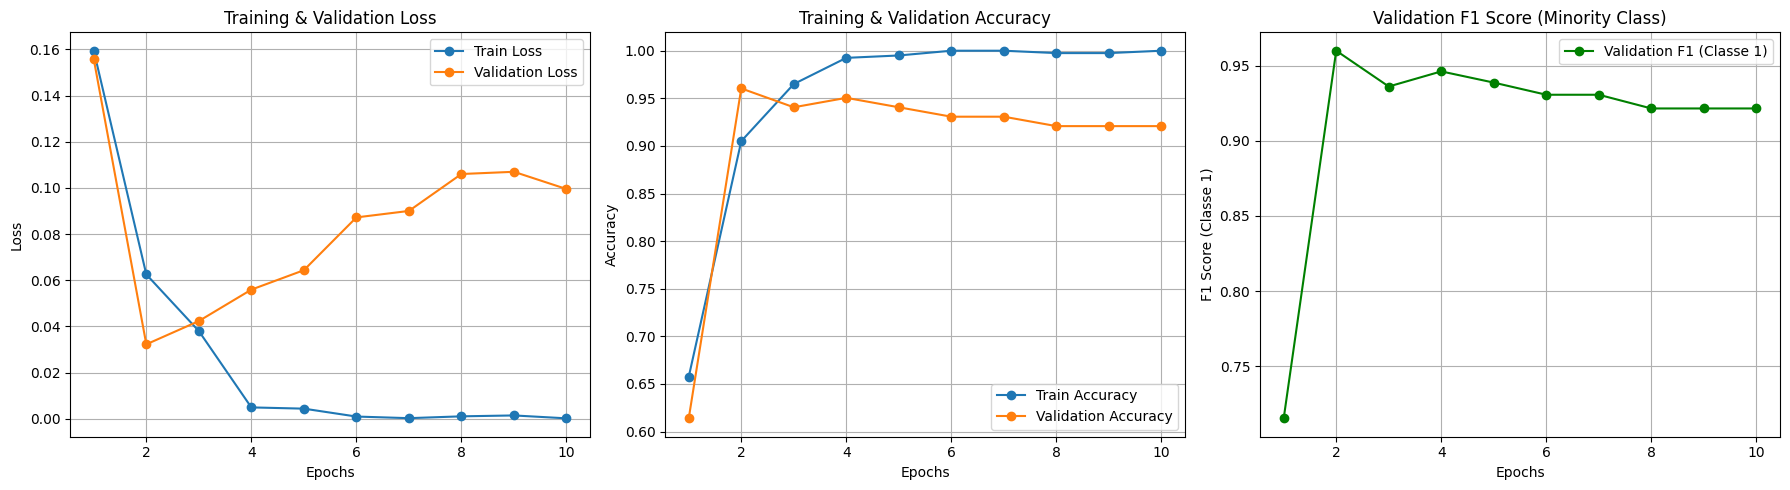

In [18]:
# --- 6. Visualisation des Courbes ---

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(18, 5))

# Plot 1: Loss (Training vs. Validation)
plt.subplot(1, 3, 1)
plt.plot(epochs_range, history['train_loss'], 'o-', label='Train Loss')
plt.plot(epochs_range, history['val_loss'], 'o-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy (Training vs. Validation)
plt.subplot(1, 3, 2)
plt.plot(epochs_range, history['train_acc'], 'o-', label='Train Accuracy')
plt.plot(epochs_range, history['val_acc'], 'o-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid(True)

# Plot 3: Validation F1-score (Minority Class)
plt.subplot(1, 3, 3)
plt.plot(epochs_range, history['val_f1_minority'], 'o-', label='Validation F1 (Classe 1)', color='green')
plt.xlabel('Epochs')
plt.ylabel('F1 Score (Classe 1)')
plt.title('Validation F1 Score (Minority Class)')
plt.legend()
plt.grid(True)

plt.tight_layout() # Ajuste automatiquement les subplots pour qu'ils ne se chevauchent pas
plt.show()

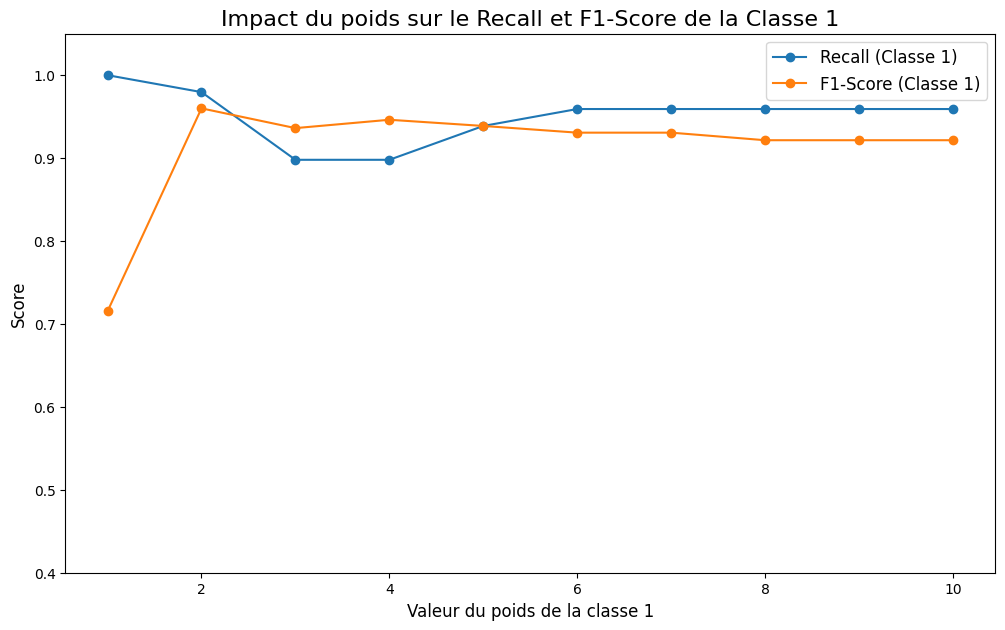

In [19]:

plt.figure(figsize=(12, 7))


plt.plot(epochs_range, history['val_recall_minority'],'o-',  label='Recall (Classe 1)')

plt.plot(epochs_range, history['val_f1_minority'],'o-', label='F1-Score (Classe 1)')




plt.title('Impact du poids sur le Recall et F1-Score de la Classe 1', fontsize=16)
plt.xlabel('Valeur du poids de la classe 1', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.legend(fontsize=12)
plt.ylim(0.4, 1.05) 
plt.show()


--- Évaluation à l'époque 9 ---


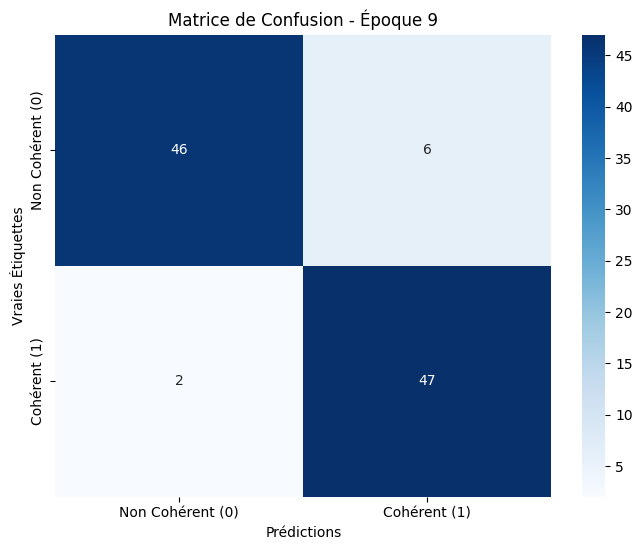

In [25]:
# --- 6. Évaluation à une époque spécifique ---
epoch_to_inspect = 9

true_labels, pred_labels = epoch_metrics[epoch_to_inspect]

# Calcule et affiche les métriques comme avant
print(f"\n--- Évaluation à l'époque {epoch_to_inspect} ---")
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Cohérent (0)', 'Cohérent (1)'], yticklabels=['Non Cohérent (0)', 'Cohérent (1)'])
plt.xlabel('Prédictions')
plt.ylabel('Vraies Étiquettes')
plt.title(f'Matrice de Confusion - Époque {epoch_to_inspect}')
plt.show()